# Project Overview

Our Analytics team will collaborate with GreatYield to explore entry into the peer lending industry and investing in peer-to-peer loans through SoftLending. We will utilize various Data Science techniques to address critical questions and deliver a final data-driven decision.

**STEP 2** ⏳

This step entails ingesting the data, executing ETL (Extract, Transform, Load), and conducting Exploratory Data Analysis (EDA) to comprehend and cleanse the data while pinpointing potential issues. It's worth noting that throughout this process, we utilized various external tools such as ChatGPT and Claude. Since a vast amount of the code was processed through AI for documentation purposes, we opted not to specify each instance where it was implemented. Additionally, we did not prioritize code optimization as it falls outside the scope of the grading criteria.






 **To do (NEXT STEP) 🏖**
 - [ ] Addressing High Cardinality and Skewness
 - [ ] Low Freq values
 - [ ] Decide what to do with il_util
 - [ ] Add expected return
 - [ ] Log transformation
 - [ ] Remove Buckets cols
 - [ ] Go over instances with 0 in 'months active'
 - [x] Fix correlation section JOE
 - [X] Outlier detection and removal
 - [X] Go over leakage coulmns again TZAHI
 - [X] Library import section TALIA
 - [x] Clean EDA & code, labels
 - [x] Save VIF extracted columns

# **Pre-Processing**
### **Importing all the Libraries**

In [137]:
#Importing libraries required for the case study and to plot charts
import numpy as np # used for scientific computing
import pandas as pd # used for data analysis and manipulation
import matplotlib.pyplot as plt # used for visualization and plotting
import seaborn as sns
import re #Importing Regular Expressions for String manipulation
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
#from dataprep.eda import plot
from datetime import datetime
import datetime as dt
from IPython.display import display
import warnings
# Ignore warnings due to version problems
warnings.filterwarnings('ignore')

from google.colab import drive
from scipy.stats import norm




### **Helper Functions**

This snippet comprises functions that will be used throught the code for it to be cleaner:

In [138]:
# was used to identify if we can remove outliers as removed in box plots
def check_normal_distribution(df, feature_name, alpha=0.10):
    """
    Check if a feature in the DataFrame is approximately normally distributed.

    Parameters:
        df (DataFrame): The DataFrame containing the feature to be checked.
        feature_name (str): The name of the feature to be checked.
        alpha (float): The significance level for the Shapiro-Wilk test.
            Default is 0.05.

    Returns:
        str: A message indicating whether the feature is approximately normally distributed.
    """
    # Extract feature data
    feature_data = df[feature_name]

    # Shapiro-Wilk Test
    shapiro_test_statistic, shapiro_p_value = stats.shapiro(feature_data)

    # Check if p-value is greater than alpha
    if shapiro_p_value > alpha:
        # Plot histogram
        plt.hist(feature_data, bins='auto')
        plt.title(f'Histogram of {feature_name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

        # Plot Q-Q plot
        stats.probplot(feature_data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {feature_name}')
        plt.xlabel('Theoretical Quantiles')
        plt.ylabel('Ordered Values')
        plt.show()

        return f"The feature '{feature_name}' is approximately normally distributed (p-value={shapiro_p_value:.4f})"
    else:
        return f"The feature '{feature_name}' is not normally distributed (p-value={shapiro_p_value:.4f})"


# # Check normality of 'loan_amnt' feature
# print(check_normal_distribution(expired_2019, 'annual_inc'))



def percentile_trim(df, feature, threshold_low=0, threshold_high=100):
    """
    Percentile-based trimming for a specified feature in a DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - feature: Name of the feature/column to trim
    - threshold_low: Lower percentile threshold (default: 0)
    - threshold_high: Upper percentile threshold (default: 100)

    Returns:
    - Trimmed DataFrame
    """
    print(f'Before removing Outliers from {feature}:\n')
    print(df[feature].describe(),'\n')

    # Calculate percentile values for the specified feature
    low_percentile_value = df[feature].quantile(threshold_low / 100)
    high_percentile_value = df[feature].quantile(threshold_high / 100)

    # Trim instances based on the specified percentile thresholds
    trimmed_df = df[(df[feature] >= low_percentile_value) & (df[feature] <= high_percentile_value)]

    print(f'After removing outliers from {feature}:\n')
    print(trimmed_df[feature].describe())

    return trimmed_df

# Example usage:
# trimmed_df = percentile_trim(df, 'feature_name', threshold_low=5, threshold_high=95)


# Example usage:
# trimmed_df = percentile_trim(df, 'feature_name', threshold_low=5, threshold_high=95)

def remove_outliers_gaussian(df, feature, sigma=3, plot=True):
    # Calculate mean and standard deviation of the feature
    mean = df[feature].mean()
    std_dev = df[feature].std()

    # Define the lower and upper bounds for outliers removal
    lower_bound = mean - sigma * std_dev
    upper_bound = mean + sigma * std_dev

    # Create a mask to identify outliers using Gaussian kernel
    mask = np.abs(df[feature] - mean) <= sigma * std_dev

    # Filter the DataFrame to remove outliers
    df_filtered = df[mask]

    # Calculate number of instances removed
    instances_removed = len(df) - len(df_filtered)

    # Plot boxplots before and after outlier removal
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Boxplot before outlier removal
        sns.boxplot(y=feature, data=df, ax=axes[0])
        axes[0].set_title('Before Outlier Removal')

        # Boxplot after outlier removal
        sns.boxplot(y=feature, data=df_filtered, ax=axes[1])
        axes[1].set_title('After Outlier Removal')

        plt.tight_layout()
        plt.show()

    print(f"Number of instances removed: {instances_removed}")

    return df_filtered
# Example usage:
# Assuming df is your DataFrame and 'feature' is the column name
# filtered_df = remove_outliers_gaussian(df, 'feature')

def plot_distribution_with_log(df, feature):
    # Plot original distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature} (Original)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Plot distribution after log transformation
    plt.subplot(1, 2, 2)
    log_feature = np.log1p(df[feature])  # Apply log transformation
    sns.histplot(log_feature, kde=True)
    plt.title(f'Distribution of log({feature} + 1)')
    plt.xlabel(f'log({feature} + 1)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Formating the time columns to create active time col

def convert_date(month_year):
    if pd.isnull(month_year):
        return ''  # Return empty string for NaN values
    try:
        # Parse the input string into a datetime object
        date_obj = datetime.strptime(month_year, '%b-%y')
    except ValueError:
        return ''  # Return empty string for invalid date formats

    # Format the datetime object into the desired short date format
    short_date = date_obj.strftime('%d/%m/%Y')

    return short_date


# Function to compute VIF for each feature
def compute_vif(features, threshold=10):
    features = features.dropna()  # Drop rows containing NaN values
    vif_data = pd.DataFrame()
    vif_data["feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    redundant_features = vif_data[vif_data["VIF"] > threshold]["feature"]
    return redundant_features

# **ETL**

### **Extracting Data**



We'll be focusing on "expired" loans from the snapshot of 2019 as we mentioned in the prior step.

In [139]:
#This code snippet may require modifications to the path and syntax if not executed in Google Colab.

#Mounting to google Drive
drive.mount('/content/drive' , force_remount=True)

# Store the path to apr 2019 snapshot CSV file
filepath = '/content/drive/My Drive/Analytics_Based_Project /loan-data-jul-2019-snap/'

q1_2019 = pd.read_csv(filepath + 'LoanStats_2016Q1.csv')
q2_2019 = pd.read_csv(filepath + 'LoanStats_2016Q2.csv')
q3_2019 = pd.read_csv(filepath + 'LoanStats_2016Q3.csv')
q4_2019 = pd.read_csv(filepath + 'LoanStats_2016Q4.csv')

Mounted at /content/drive


In [140]:

# Remove the title row from each quarterly file for 2019
# q2_2019 = q2_2019.iloc[1:]
# q3_2019 = q3_2019.iloc[1:]
# q4_2019 = q4_2019.iloc[1:]

# Concatenate the quarterly files for 2019 into a single dataframe
snap_2019 = pd.concat([q1_2019, q2_2019, q3_2019, q4_2019], axis=0)


In [141]:
# Creating a df for the expired loans
expired_2019 = snap_2019[(snap_2019['loan_status'] == 'Fully Paid') | (snap_2019['loan_status'] == 'Charged Off')]
print(len(expired_2019))


335003


In [142]:
# Percent of expired loans out of snap_2019
percantage = (len(expired_2019) / len(snap_2019)) * 100
print(f"The percantage of rows in expired_2019 out of the number of rows in snap_2019 is {percantage:.2f}%")


The percantage of rows in expired_2019 out of the number of rows in snap_2019 is 77.11%


We'll be extracting expired loans from 2018 too, only to test leakage among out features


In [143]:
#Mounting to google Drive
drive.mount('/content/drive' , force_remount=True)

# Store the path to apr 2019 snapshot CSV file
filepath = '/content/drive/My Drive/Analytics_Based_Project /loan-data-apr-2018-snap/'

q1_2018 = pd.read_csv(filepath + 'LoanStats_2016Q1.csv')
q2_2018 = pd.read_csv(filepath + 'LoanStats_2016Q2.csv')
q3_2018 = pd.read_csv(filepath + 'LoanStats_2016Q3.csv')
q4_2018 = pd.read_csv(filepath + 'LoanStats_2016Q4.csv')

Mounted at /content/drive


In [144]:
snap_2018 = pd.concat([q1_2018, q2_2018, q3_2018, q4_2018], axis=0) #sticking together the data frames rows under rows - axis=0
expired_2018 = snap_2018[(snap_2018['loan_status'] == 'Fully Paid') | (snap_2018['loan_status'] == 'Charged Off')] # only instances which in the loan status column- fully paidcharged off


### **Transformation**

### **Data Cleaning & Feature Selection**

Features and data types

In [145]:
# using a for loop print the tiltle of each column and its data type
count=0
for column_name in expired_2019.columns:
  print(f"- {column_name}, {expired_2019[column_name].dtype}")
  count+=1

print('----------------------------------------------')
print('numeber of columns =', count)

- id, object
- member_id, float64
- loan_amnt, float64
- funded_amnt, float64
- funded_amnt_inv, float64
- term, object
- int_rate, object
- installment, float64
- grade, object
- sub_grade, object
- emp_title, object
- emp_length, object
- home_ownership, object
- annual_inc, float64
- verification_status, object
- issue_d, object
- loan_status, object
- pymnt_plan, object
- url, object
- desc, object
- purpose, object
- title, object
- zip_code, object
- addr_state, object
- dti, float64
- delinq_2yrs, float64
- earliest_cr_line, object
- fico_range_low, float64
- fico_range_high, float64
- inq_last_6mths, float64
- mths_since_last_delinq, float64
- mths_since_last_record, float64
- open_acc, float64
- pub_rec, float64
- revol_bal, float64
- revol_util, object
- total_acc, float64
- initial_list_status, object
- out_prncp, float64
- out_prncp_inv, float64
- total_pymnt, float64
- total_pymnt_inv, float64
- total_rec_prncp, float64
- total_rec_int, float64
- total_rec_late_fee, float6

Plot of the Nan Values

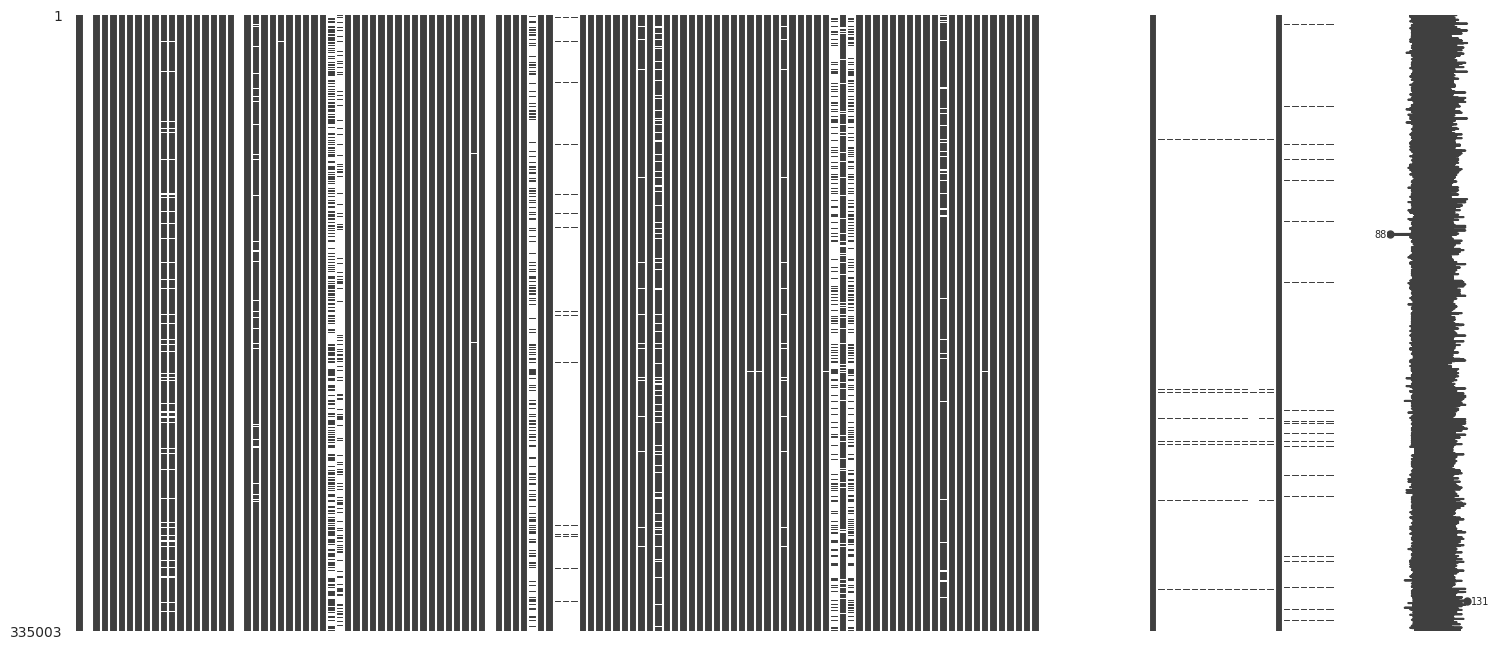

In [146]:

msno.matrix(expired_2019, labels=False, fontsize=8) #removed labels since they are too crowded
plt.gcf().set_size_inches(18, 8)
plt.show()


il_util is calculated by dividing the total current balance on installment loans by the total credit limit on all installment accounts and expressing the result as a percentage.

In [147]:
# Count the number of instances with missing il_util
missing_il_util_count = expired_2019['il_util'].isna().sum()

# Calculate il_util for instances with missing values
expired_2019.loc[expired_2019['il_util'].isna(), 'il_util'] = (expired_2019.loc[expired_2019['il_util'].isna(), 'total_bal_il'] / expired_2019.loc[expired_2019['il_util'].isna(), 'total_il_high_credit_limit']) * 100

# Count the number of instances with successfully completed il_util
completed_il_util_count = missing_il_util_count - expired_2019['il_util'].isna().sum()

# Print the number of instances with successfully completed il_util
print(f"Successfully completed il_util for {completed_il_util_count} instances.")


Successfully completed il_util for 10589 instances.


Removing features based On NAn treshold of 50% **(We double checked the removed features and no potentialy predictive/critical column that could have been recovered was removed)**

In [148]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Store the original column names
original_columns = expired_2019.columns.tolist()

# Drop all columns from expired_2019 that hold 50% or more NaN
removed_columns = expired_2019.columns[expired_2019.isnull().mean() >= 0.5].tolist()
expired_2019.dropna(thresh=int(expired_2019.shape[0] * 0.5), axis=1, inplace=True)

# Calculate the number of removed columns
# Print the columns that were removed and the number of columns removed
print("Columns removed ({}):".format(len(removed_columns)), removed_columns)

# expired_2019.head()


Columns removed (43): ['member_id', 'desc', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlem

**Removing No Variance Columns**

In [149]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# printing uniue value features
cols_with_same_values = expired_2019.loc[:, expired_2019.nunique() == 1].columns

print("Columns with the same value in all rows:")
for column_name in cols_with_same_values:
    print(column_name)

# Drop columns that all the values are the same
expired_2019.drop(columns=expired_2019.loc[:, expired_2019.nunique() == 1].columns, inplace=True)


Columns with the same value in all rows:
pymnt_plan
out_prncp
out_prncp_inv
policy_code
hardship_flag


**Excluding Columns Based on Percent Change in Values Across 2018 and 2019- preventing data leakage**





In [150]:
# Merging 2018 and 2019 data frames on id, including only columns that exist in 2019
expired_both_years = pd.merge(expired_2019, expired_2018[expired_2019.columns], on='id', suffixes=('_19', '_18'))

# Percent change in rows for each feature (excluding id)
changed_features = {}
for column in expired_2019.columns:
    if column == 'id':  # Skip the 'id' column
        continue
    non_na_rows = expired_both_years[[f"{column}_18", f"{column}_19"]].dropna()
    changed_rows = (non_na_rows[f"{column}_18"] != non_na_rows[f"{column}_19"]).sum()
    percent_change = changed_rows / len(non_na_rows) * 100
    if percent_change > 0:
        changed_features[column] = percent_change

# Sorting and displaying results (some of the columns that changed where removed preliminary to this phase)
for feature, percent_change in sorted(changed_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {percent_change:.5f}% changed")


last_credit_pull_d: 61.36961% changed
last_fico_range_high: 56.99843% changed
last_fico_range_low: 56.99843% changed
total_pymnt: 7.95232% changed
total_pymnt_inv: 7.93559% changed
recoveries: 7.93559% changed
collection_recovery_fee: 7.93559% changed
verification_status: 1.30395% changed
debt_settlement_flag: 0.79298% changed
last_pymnt_amnt: 0.00461% changed
last_pymnt_d: 0.00289% changed
total_rec_int: 0.00288% changed
total_rec_prncp: 0.00115% changed
total_rec_late_fee: 0.00115% changed


In [151]:
# removing last_pymnt_d since it will be used to calculate moths active and emp_length , albeit it changed we dont see it as leakage
changed_features.pop('last_pymnt_d','emp_length')

# Drop from expired_2019 df the keys of dictionary changed_features
expired_2019.drop(list(changed_features.keys()), axis=1, inplace=True)

# Print the names of the dropped columns
print("The following columns were dropped:")
for column in list(changed_features.keys()):
    print(column)




The following columns were dropped:
verification_status
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_credit_pull_d
last_fico_range_high
last_fico_range_low
debt_settlement_flag


In [152]:
# # number of unemployed instances

# unemployed_count = expired_2019[expired_2019['EmpStatusFlag'] == 0].shape[0]
# print(f"Number of unemployed borrowers: {unemployed_count}")




**post-loan features + data understanding (irrelevant for our analysis)**








In [153]:
# omitting features based on data understanding and leakage
omit_features = ['id','url','title','zip_code', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m','acc_now_delinq','tot_coll_amt','tot_cur_bal','collections_12_mths_ex_med','mths_since_last_delinq','chargeoff_within_12_mths','funded_amnt',
'funded_amnt_inv', 'mths_since_recent_bc','mths_since_recent_inq','inq_last_6mths','mths_since_rcnt_il','mo_sin_old_il_acct','mths_since_recent_bc','mths_since_recent_inq','num_tl_120dpd_2m','percent_bc_gt_75']
expired_2019.drop(omit_features, axis=1, inplace=True)



**High Correlation Analysis**

This code identifies highly correlated numeric columns in the DataFrame expired_2019 and selects one feature from each group to reduce redundancy and multicollinearity. By keeping only one feature from each correlated group, we maintain data integrity while improving model interpretability and performance.



**Features we decided to keep**

1. 'loan_amnt': Directly represents the principal amount borrowed, crucial for lending decisions.

2. 'fico_range_low': Represents the lower end of the FICO credit score range, providing a conservative estimate of creditworthiness.

3. 'open_acc': Commonly used and understood, represents the number of open credit accounts.

4. The more conservative option would be to choose 'total_bal_ex_mort' as it excludes mortgage balances, potentially providing a clearer picture of the borrower's financial situation.

5. 'total_bal_il': Represents the total current balance of all installment accounts, providing comprehensive financial information.

6. 'num_actv_rev_tl': Represents the number of currently active revolving credit accounts, essential for assessing credit activity.

In [154]:
# prompt: rint all column groups/pairs in expired_2019 that hold more than 0.9 correlation , make sure you are comparing the correct data types


# Filter only numeric columns
numeric_cols = expired_2019.select_dtypes(include='number').columns

# Initialize list to store correlated groups
correlated_groups = []

# Iterate over numeric columns
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        # Compute correlation
        corr = expired_2019[col1].corr(expired_2019[col2])
        # Check if correlation exceeds threshold
        if abs(corr) >= 0.899:
            # Append correlated groups to list
            correlated_groups.append((col1, col2))

# Print correlated groups and their correlation values
for group in correlated_groups:
    corr_value = expired_2019[group[0]].corr(expired_2019[group[1]])
    print(f"Columns '{group[0]}' and '{group[1]}' are correlated with a value of {corr_value}")

print('--------------------------')

features_to_drop = [
    'installment',  # From 'loan_amnt' and 'installment' group
    'fico_range_high',  # From 'fico_range_low' and 'fico_range_high' group
    'num_sats',  # From 'open_acc' and 'num_sats' group
    'total_bal_ex_mort',  # From 'total_bal_il' and 'total_bal_ex_mort' group
    'total_il_high_credit_limit',  # From 'total_bal_il' and 'total_il_high_credit_limit' group
    'num_rev_tl_bal_gt_0',  # From 'num_actv_rev_tl' and 'num_rev_tl_bal_gt_0' group
    'total_bal_il' # conservative approach
]

# Drop the features from expired_2019 DataFrame
expired_2019.drop(columns=features_to_drop, inplace=True)

# Print the names of the dropped features
print("Features removed due to high correlation:")
for feature in features_to_drop:
    print(feature)

Columns 'loan_amnt' and 'installment' are correlated with a value of 0.9605148874234265
Columns 'fico_range_low' and 'fico_range_high' are correlated with a value of 0.9999999081655243
Columns 'open_acc' and 'num_sats' are correlated with a value of 0.9986717137302457
Columns 'total_bal_il' and 'total_il_high_credit_limit' are correlated with a value of 0.9589045168021119
Columns 'num_actv_rev_tl' and 'num_rev_tl_bal_gt_0' are correlated with a value of 0.9776483021754458
--------------------------
Features removed due to high correlation:
installment
fico_range_high
num_sats
total_bal_ex_mort
total_il_high_credit_limit
num_rev_tl_bal_gt_0
total_bal_il


In [155]:
# number and names of the remianing features

count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


1- loan_amnt
2- term
3- int_rate
4- grade
5- sub_grade
6- emp_title
7- emp_length
8- home_ownership
9- annual_inc
10- issue_d
11- loan_status
12- purpose
13- addr_state
14- dti
15- delinq_2yrs
16- earliest_cr_line
17- fico_range_low
18- open_acc
19- pub_rec
20- revol_bal
21- revol_util
22- total_acc
23- initial_list_status
24- last_pymnt_d
25- application_type
26- open_act_il
27- il_util
28- max_bal_bc
29- all_util
30- total_rev_hi_lim
31- total_cu_tl
32- acc_open_past_24mths
33- avg_cur_bal
34- bc_open_to_buy
35- bc_util
36- delinq_amnt
37- mo_sin_old_rev_tl_op
38- mo_sin_rcnt_rev_tl_op
39- mo_sin_rcnt_tl
40- mort_acc
41- num_accts_ever_120_pd
42- num_actv_bc_tl
43- num_actv_rev_tl
44- num_bc_sats
45- num_bc_tl
46- num_il_tl
47- num_op_rev_tl
48- num_rev_accts
49- num_tl_30dpd
50- num_tl_90g_dpd_24m
51- num_tl_op_past_12m
52- pct_tl_nvr_dlq
53- pub_rec_bankruptcies
54- tax_liens
55- tot_hi_cred_lim
56- total_bc_limit


###**High cardinality** - We'll touch upon the topic of high cardinality now, but we'll delve deeper into it during the subsequent stage of data preparation."

high cardinality in the employees title

```
`# This is formatted as code`
```



In [156]:
#creating a new column EmpStatusFlag-  binary indicator by assigning 1 to employed individuals and 0 to unemployed individualsg .the code:

# expired_2019['EmpStatusFlag'] = expired_2019['emp_title'].fillna('').apply(lambda x: 1 if len(x) > 0 else 0)


In [157]:
#  print the number of instances known as unemployed

# unemployed_count = expired_2019[expired_2019['EmpStatusFlag'] == 0].shape[0]
# print(f"Number of unemployed borrowers: {unemployed_count}")


high cardinality in 'addr_state'


In [158]:
# dividing the states into 5 clusters (10 in each) based on median household income data. 1 is the highest median 5 is the lowest

# def create_state_income_cluster(df):
#   """
#   Creates a new column representing state-household income cluster.

#   Args:
#       df: DataFrame containing the data.

#   Returns:
#       DataFrame with the new column.
#   """

#   # Define the clusters
#   cluster1 = ['NJ', 'MD', 'MA', 'HI', 'CA', 'WA', 'NH', 'CO', 'UT', 'CT']
#   cluster2 = ['AK', 'VA', 'MN', 'DE', 'RI', 'NY', 'IL', 'OR', 'AZ', 'VT']
#   cluster3 = ['GA', 'ID', 'NV', 'TX', 'ND', 'PA', 'WI', 'WY', 'SD', 'NE']
#   cluster4 = ['IA', 'ME', 'FL', 'KS', 'MT', 'NC', 'MI', 'IN', 'OH', 'TN']
#   cluster5 = ['MO', 'SC', 'NM', 'AL', 'OK', 'KY', 'AR', 'LA', 'WV', 'MS']

#   # Create a new column based on the clusters
#   df['StateIncomeCluster'] = df['addr_state'].apply(lambda state:
#                                                    1 if state in cluster1 else
#                                                    2 if state in cluster2 else
#                                                    3 if state in cluster3 else
#                                                    4 if state in cluster4 else
#                                                    5)

#   return df

# # Apply the function to the DataFrame
# expired_2019 = create_state_income_cluster(expired_2019)



### **In this section we'll focus on the instances we want to disregard or alter**

**Checking for Duplicates**



In [159]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# print the number of duplicates on expired_2019

print('Number of duplicates:', expired_2019.duplicated().sum())


Number of duplicates: 0


**Removing loans that are missing critical features**


NEEDS to be re-considered!!!!

In [160]:

# Define your dataframe expired_2019 and critical_features
critical_features = critical_features = [
    'loan_status', 'annual_inc', 'dti', 'earliest_cr_line', 'loan_amnt', 'int_rate', 'purpose',
     'emp_length', 'home_ownership', 'addr_state','last_pymnt_d','issue_d',
]

# Count instances before removal
instances_before_removal = len(expired_2019)

# Check for NaN values in critical features and remove corresponding instances
expired_2019_cleaned = expired_2019.dropna(subset=critical_features)

# Count instances after removal
instances_after_removal = len(expired_2019_cleaned)

# Calculate the number of removed instances
removed_instances = instances_before_removal - instances_after_removal

# Update expired_2019 with cleaned data
expired_2019 = expired_2019_cleaned.copy()

# Print the count of removed instances
print(f"Removed {removed_instances} instances due to missing values in critical features.")


Removed 22550 instances due to missing values in critical features.


**Removing instances with multiple nans**


In [161]:
# generate a code that drops the instances with 3 or more nans and the prints the number of instances removed from expired_2019

# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Count instances before removal
instances_before_removal = len(expired_2019)

# Drop instances with 5 or more NaN values
expired_2019 = expired_2019.dropna(thresh=len(expired_2019.columns) - 3)

# Count instances after removal
instances_after_removal = len(expired_2019)

# Calculate the number of removed instances
removed_instances = instances_before_removal - instances_after_removal

# Print the count of removed instances
print(f"Removed {removed_instances} instances with 3 or more NaN values.")


Removed 60 instances with 3 or more NaN values.


To simplify our analysis, we've chosen to temporarily **exclude joint loan** applications. They represent only a small fraction of the total loans, and their secondary features might affect the analysis of other loans. ( We might do a separate analysis on joint loans in the feature.)

In [162]:
# This snippet prints the percantage of 'Individual' and 'Joint App' in application_type , then drop all instances that hold in 'application_type 'Joint App' and lasttly drop the application_type column

# Calculate the percentage of 'Individual' and 'Joint App' in application_type
application_type_counts = expired_2019['application_type'].value_counts()
individual_percentage = (application_type_counts['Individual'] / application_type_counts.sum()) * 100
joint_percentage = (application_type_counts['Joint App'] / application_type_counts.sum()) * 100

# Print the percentage
print(f"Percentage of 'Joint App': {joint_percentage:.2f}%")

# Drop all instances that have 'Joint App' in 'application_type'
expired_2019= expired_2019[expired_2019['application_type'] != 'Joint App']

# Drop the application_type column
expired_2019.drop(columns=['application_type'], inplace=True)
application_type_counts


Percentage of 'Joint App': 1.73%


10 features with the highest Nan %

In [163]:
# calculate the percentage of nan values of each column, show the top ten highest percentages

# Calculate the percentage of NaN values in each column
nan_percentages = expired_2019.isna().mean() * 100

# Sort the percentages in descending order and select the top 10
top_ten_nan_percentages = nan_percentages.sort_values(ascending=False).head(10)

# Print the top 10 highest percentages
print(top_ten_nan_percentages)

il_util           9.150816
bc_util           1.086032
bc_open_to_buy    1.035868
emp_title         0.120525
revol_util        0.055377
all_util          0.000651
total_cu_tl       0.000326
num_actv_bc_tl    0.000000
avg_cur_bal       0.000000
delinq_amnt       0.000000
dtype: float64


<Axes: >

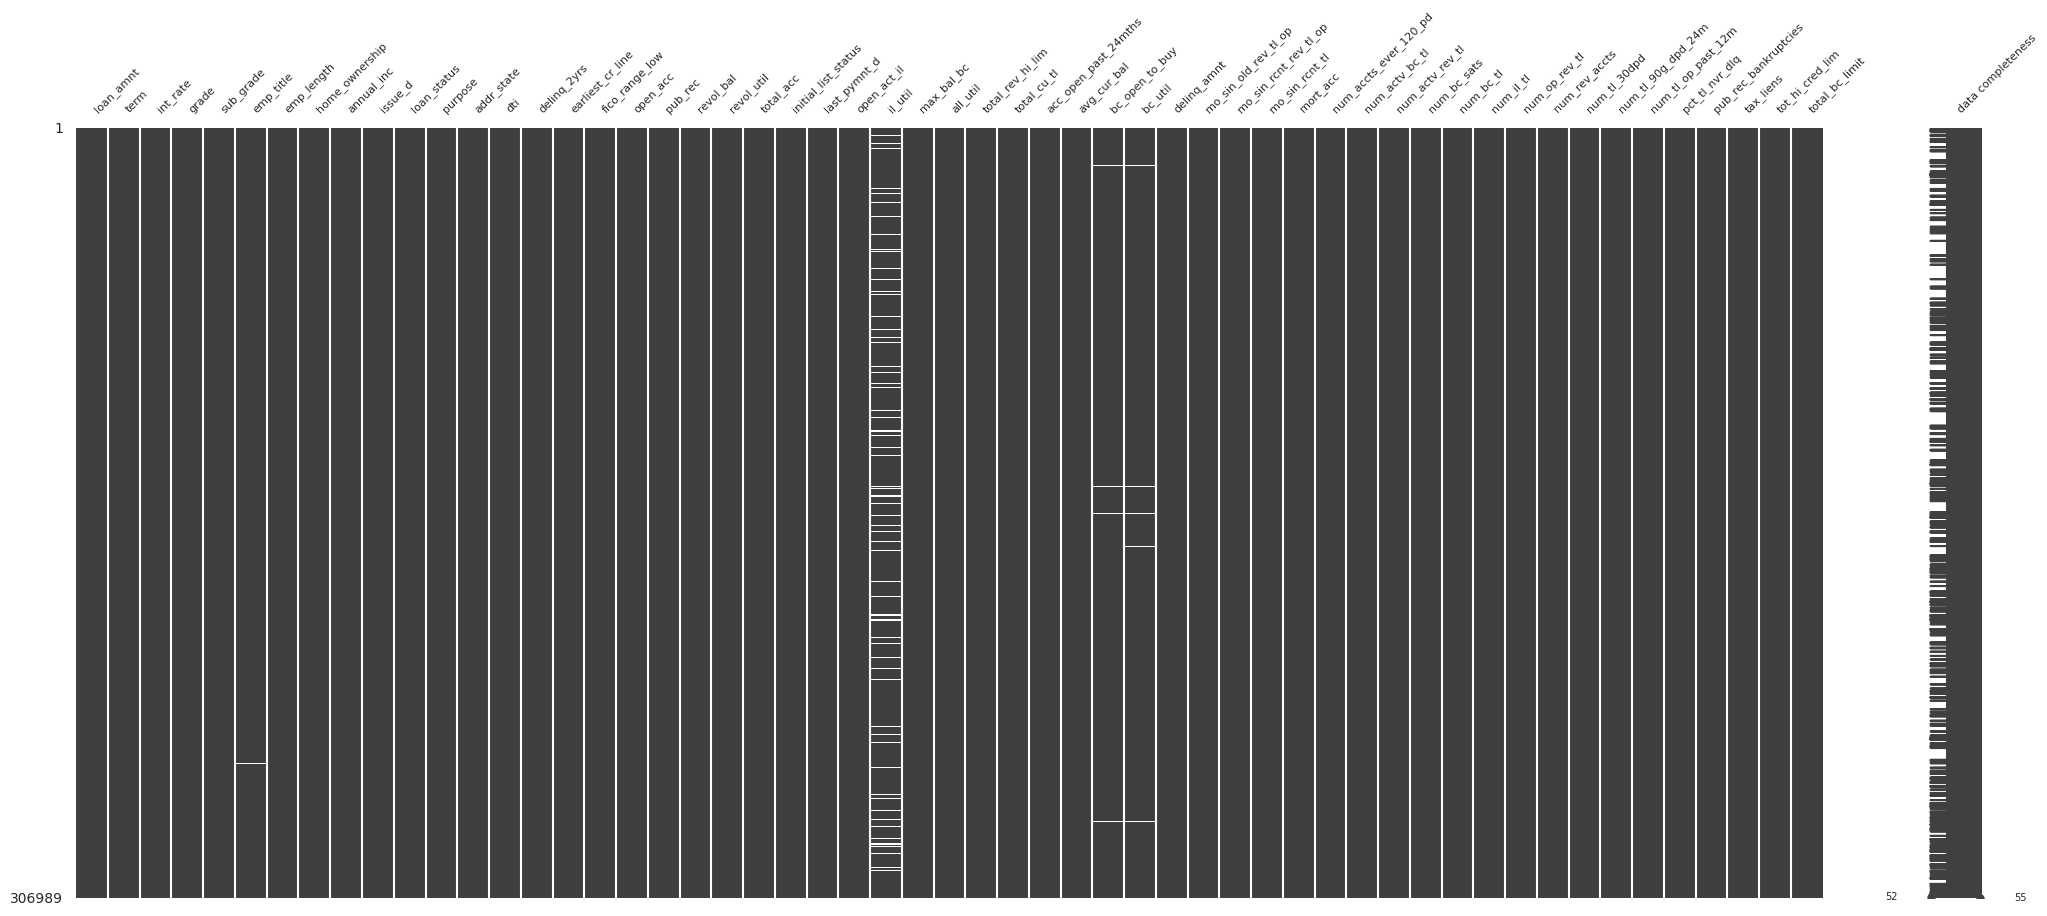

In [164]:
# NAn plot after cleansing
msno.matrix(expired_2019, labels=True, fontsize=8)

In [165]:
# prompt: please print the number of remaining features in expired_2019 data frame and also the names of the features

print(f'Number of remaining columns: {expired_2019.shape[1]}')
print('Remaining columns:')
for column in expired_2019.columns:
    print(column)


Number of remaining columns: 55
Remaining columns:
loan_amnt
term
int_rate
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
issue_d
loan_status
purpose
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
last_pymnt_d
open_act_il
il_util
max_bal_bc
all_util
total_rev_hi_lim
total_cu_tl
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
delinq_amnt
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bc_limit


In [166]:
# prompt: now output the number of instances we have in expired_2019

print(f"Number of remaining instances: {expired_2019.shape[0]}")


Number of remaining instances: 306989


### **Formating Data**

Changing the loan status to be numeric

In [167]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Take the loan_status column and change the values from 'Charged Off' to be 1 and  to be 0 'Fully Paid'.
#print(expired_2019['loan_status'].head())
expired_2019['loan_status'] = expired_2019['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
#print(expired_2019['loan_status'].type())

In [168]:
# # !pip install dataprep
# from dataprep.eda import plot
# plot(expired_2019)

Extracting the Total Months active Column (**still need to go ove the 0 active months instances + has new bug needs to be fixed**):

In [169]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

expired_2019['last_pymnt_d'] = expired_2019['last_pymnt_d'].astype(str)
expired_2019['last_pymnt_d'] = expired_2019['last_pymnt_d'].apply(convert_date)

expired_2019['issue_d'] = expired_2019['issue_d'].astype(str)
expired_2019['issue_d'] = expired_2019['issue_d'].apply(convert_date)

# Convert the 'last_pymnt_d' and 'issue_d' columns to datetime objects
expired_2019['last_pymnt_d'] = pd.to_datetime(expired_2019['last_pymnt_d'], format='%d/%m/%Y')
expired_2019['issue_d'] = pd.to_datetime(expired_2019['issue_d'], format='%d/%m/%Y')

# Calculate the difference between the two datetime columns in months
expired_2019['Total_Months_Active'] = (expired_2019['last_pymnt_d'] - expired_2019['issue_d']).dt.days // 30

expired_2019['Total_Months_Active'] = expired_2019['Total_Months_Active'].fillna(0)
expired_2019['Total_Months_Active'] = expired_2019['Total_Months_Active'].astype(int)


We'll need to adress the features with 0 active months in the next step

In [170]:
# print the instances that have 0 on the Total_Months_Active

# expired_2019[expired_2019['Total_Months_Active'] == 0]


Parcing and changing data types


In [171]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Extracting the number out of the emp_length
expired_2019['emp_length']=expired_2019.emp_length.str.extract('(\d+)')
expired_2019['emp_length'] = expired_2019['emp_length'].astype(int)


# parse from the column 'term' in expired_2019 the word 'months' and convert it into int

expired_2019['term'] = expired_2019['term'].str.replace(' months', '')
expired_2019['term'] = expired_2019['term'].astype(int)

# # Removing the 'xx' from the zip_code column and changing the data type to int
# expired_2019['zip_code'] = expired_2019['zip_code'].str.replace('xx', '')
# expired_2019['zip_code'] = expired_2019['zip_code'].astype(int)

# Removing the '%' sign from the revol_util column and changing the data type to double
expired_2019['revol_util'] = expired_2019['revol_util'].str.replace('%', '')
expired_2019['revol_util'] = expired_2019['revol_util'].astype(float)

# Removing the '%' sign from the int_rate column and changing the data type to double
expired_2019['int_rate'] = expired_2019['int_rate'].str.replace('%', '')
expired_2019['int_rate'] = expired_2019['int_rate'].astype(float)


# # Changing the 'Y' to 1 and the 'N' to 0 in the debt_settlement_flag column
# expired_2019['debt_settlement_flag'] = expired_2019['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)


In [172]:
# print the unique values of expired_2019['emp_length']

print(expired_2019['emp_length'].unique())


[ 9  5  6 10  1  8  3  4  2  7]


Optional geographical grouping (We'll decide on the next step if we want to incorporate)

Non numerical Features after first formating :

In [173]:
# print the tittle of all the non numerical columns

non_numerical_cols = expired_2019.select_dtypes(include=['object']).columns
for col in non_numerical_cols:
    print(col)

grade
sub_grade
emp_title
home_ownership
purpose
addr_state
earliest_cr_line
initial_list_status


Checking Features and data-types after ETL

In [174]:
# using a for loop print the tiltle of each column and its data type
count=0
for column_name in expired_2019.columns:
  print(f"- {column_name}, Data Type: {expired_2019[column_name].dtype}")
  count+=1

print('----------------------------------------------')
print('numeber of columns =', count)

- loan_amnt, Data Type: float64
- term, Data Type: int64
- int_rate, Data Type: float64
- grade, Data Type: object
- sub_grade, Data Type: object
- emp_title, Data Type: object
- emp_length, Data Type: int64
- home_ownership, Data Type: object
- annual_inc, Data Type: float64
- issue_d, Data Type: datetime64[ns]
- loan_status, Data Type: int64
- purpose, Data Type: object
- addr_state, Data Type: object
- dti, Data Type: float64
- delinq_2yrs, Data Type: float64
- earliest_cr_line, Data Type: object
- fico_range_low, Data Type: float64
- open_acc, Data Type: float64
- pub_rec, Data Type: float64
- revol_bal, Data Type: float64
- revol_util, Data Type: float64
- total_acc, Data Type: float64
- initial_list_status, Data Type: object
- last_pymnt_d, Data Type: datetime64[ns]
- open_act_il, Data Type: float64
- il_util, Data Type: float64
- max_bal_bc, Data Type: float64
- all_util, Data Type: float64
- total_rev_hi_lim, Data Type: float64
- total_cu_tl, Data Type: float64
- acc_open_past_

In [175]:
# # Set to display all columns
# pd.set_option('display.max_columns', None)

# # Assuming expired_2019 is your DataFrame
# display(expired_2019.head())


In [176]:
# Print the columns that have NAn and the count for each column
# Assuming expired_2019 is your DataFrame
nan_counts = expired_2019.isna().sum()

# Get column names with NaN values
columns_with_nan = nan_counts[nan_counts > 0].index.tolist()

# Print the columns and their respective NaN counts
for column in columns_with_nan:
    print(f"{column}: {nan_counts[column]}")


emp_title: 370
revol_util: 170
il_util: 28092
all_util: 2
total_cu_tl: 1
bc_open_to_buy: 3180
bc_util: 3334


### **Outliers Detection and Removal**

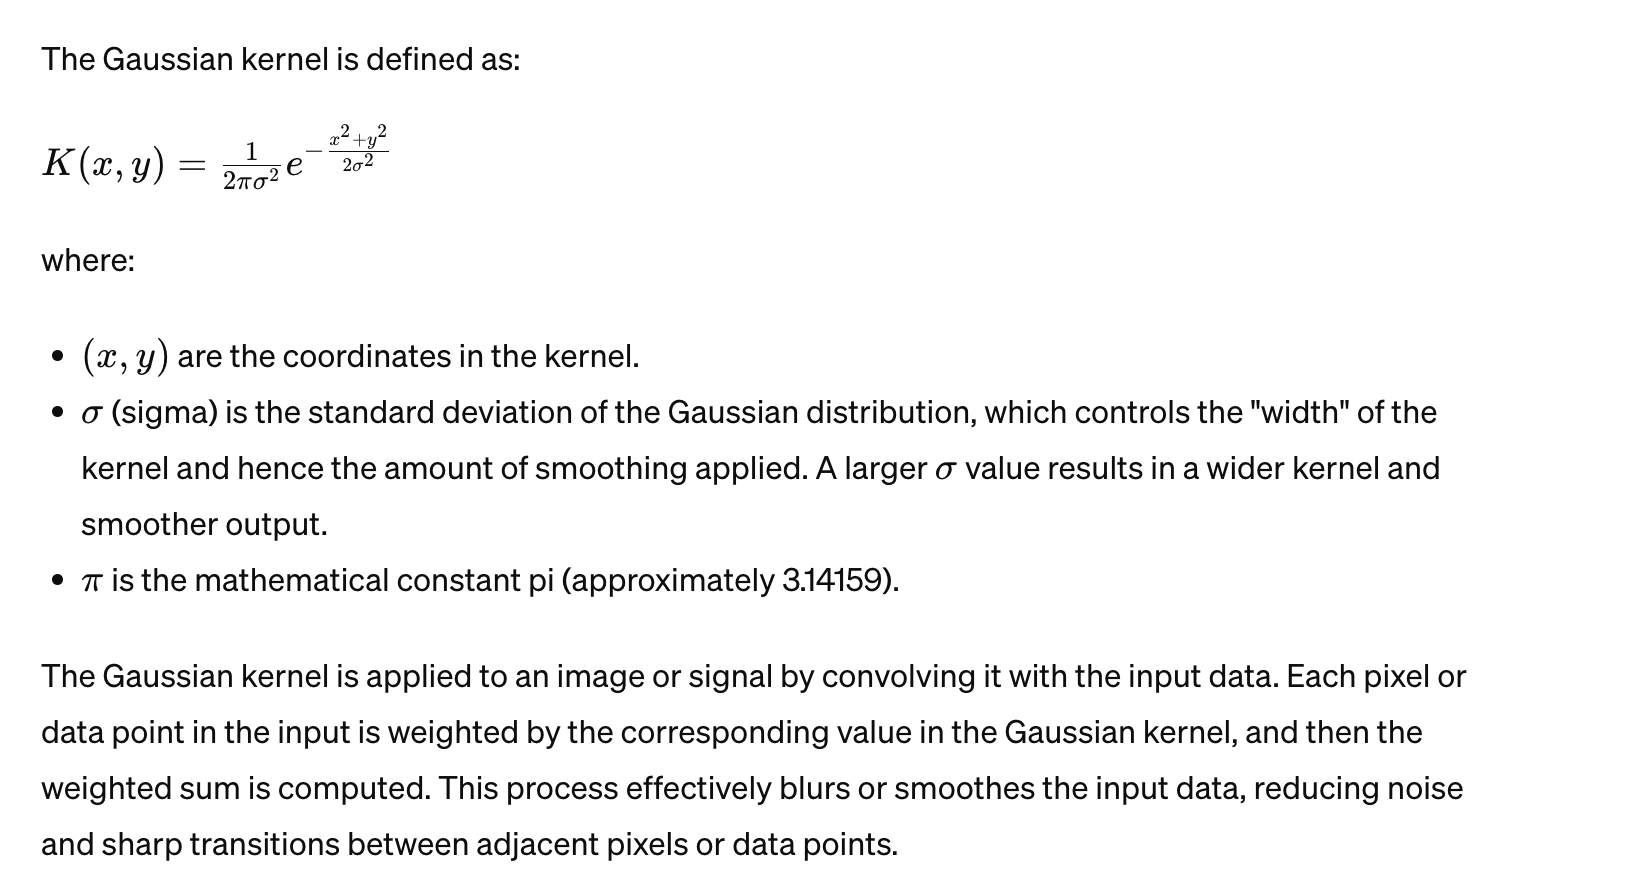



 The function **remove_outliers_gaussia** (found in the helper functions section) effectively removes outliers from a specified feature in a DataFrame using a Gaussian kernel approach. By calculating the mean and standard deviation of the feature, it defines bounds for outlier detection. Employing the Gaussian kernel method, it creates a mask to identify outliers, subsequently filtering the DataFrame to exclude these data points.The function plots boxplots of the feature's distribution before and after outlier removal, providing visual insights. Additionally, it prints the number of instances removed, facilitating a quantitative understanding of the impact of outlier removal. Overall, this function offers a concise and comprehensive solution for outlier removal in data analysis tasks.

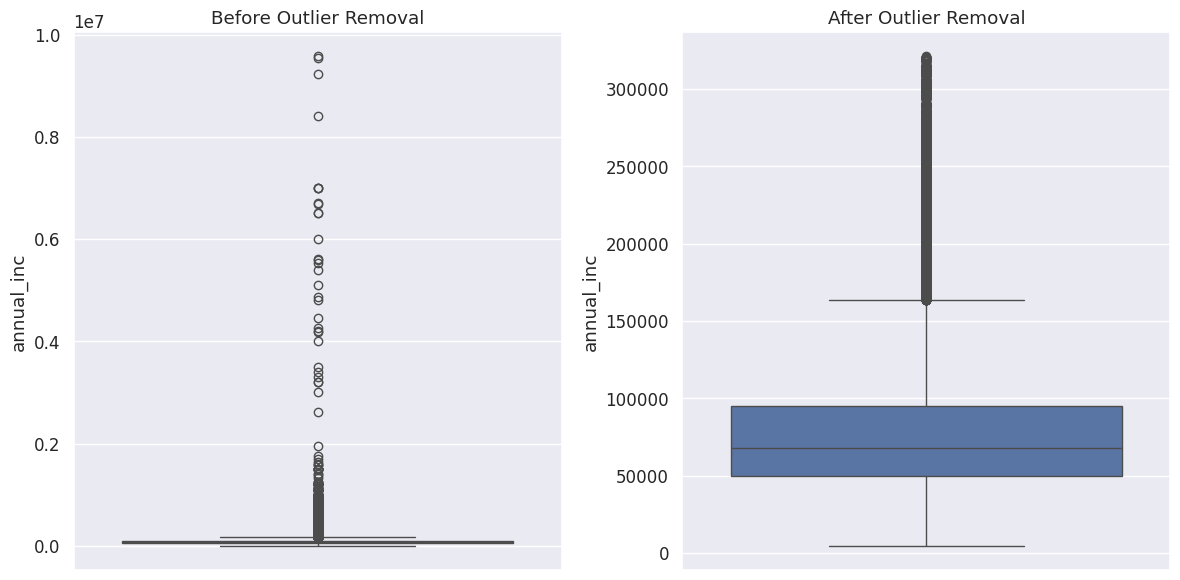

Number of instances removed: 2005


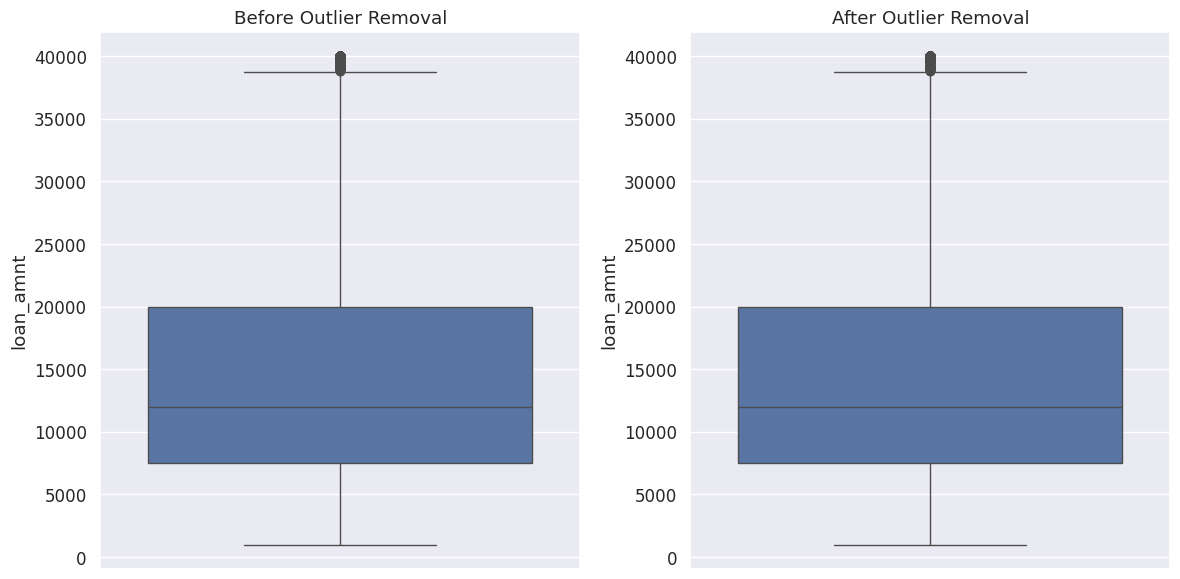

Number of instances removed: 0


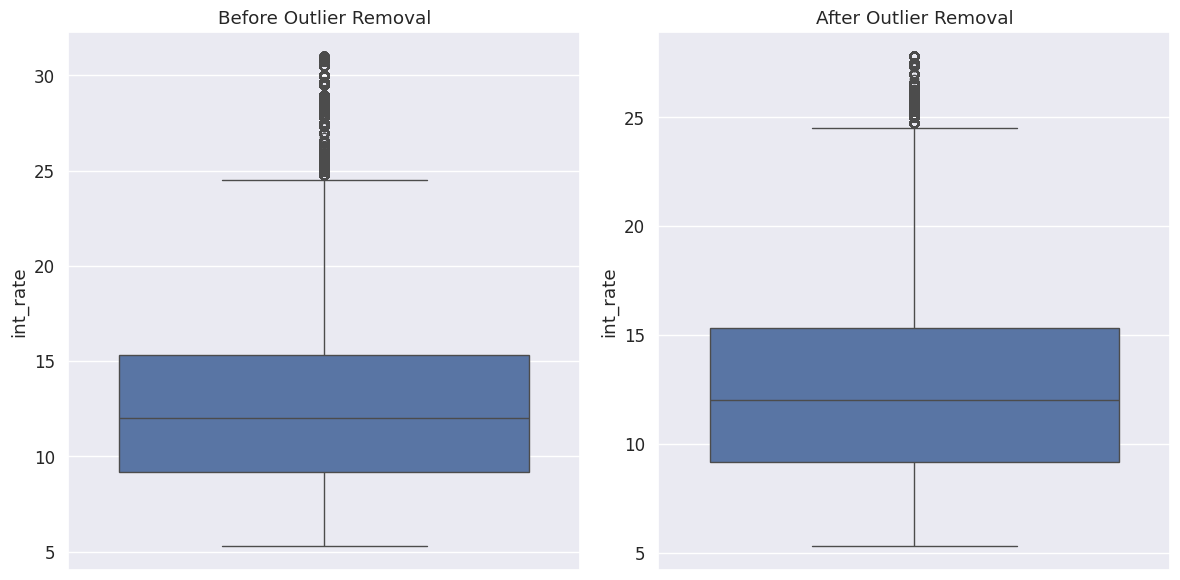

Number of instances removed: 2371


In [177]:
# We decided for now not to use this method
# percentile_trim(expired_2019, 'annual_inc', threshold_low=5, threshold_high=95)
# percentile_trim(expired_2019, 'loan_amnt', threshold_low=5, threshold_high=95)
# percentile_trim(expired_2019, 'int_rate', threshold_low=5, threshold_high=95)



expired_2019 = remove_outliers_gaussian(expired_2019, 'annual_inc')
expired_2019 = remove_outliers_gaussian(expired_2019, 'loan_amnt')
expired_2019 = remove_outliers_gaussian(expired_2019, 'int_rate')





Since the Kernel gaussian outlier didnt completly treat the outliers we'll consider using log transformation to prevent bieased results. Bellow is an example of the results of log transformation, this will be enforced and further analysed for pitfalls in the implementation.

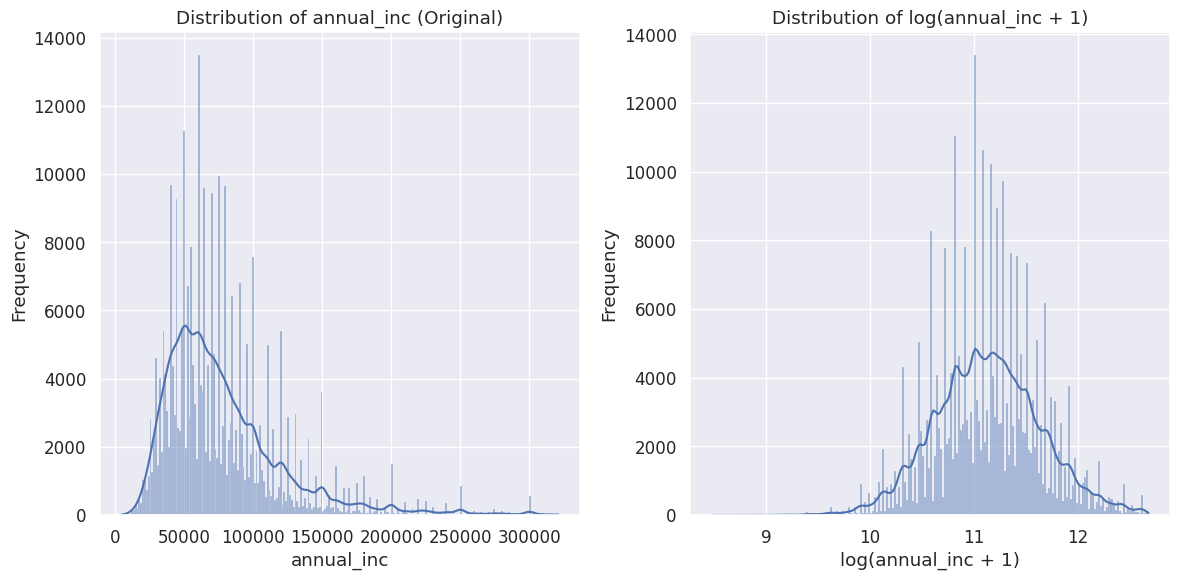

In [178]:

plot_distribution_with_log(expired_2019, 'annual_inc')


# **EDA**

### Creating Buckets for analysis

In [179]:
#Creating Bins for further analysis
#Creating categories for loan amounts for further bivariate analysis
expired_2019['loan_amnt_cat']=pd.cut(expired_2019['loan_amnt'],[0,7000,14000,21000,28000,35000],labels=['0-7000','7000-14000','14000-21000','21000-28000','28000+'])

#Creating categories for annual incomes for further bivariate analysis
expired_2019['annual_inc_cat']=pd.cut(expired_2019['annual_inc'],[0,20000,40000,60000,80000,1000000],labels=['0-20000','20000-40000','40000-60000','60000-80000','80000+'])

# Create Interest Rate Category
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%']
expired_2019['int_rate_cat'] = pd.cut(expired_2019['int_rate'], bins=bins, labels=labels)
#Creating dti into buckets for further bivariate analysis

# print(expired_2019.shape)

# expired_2019.head(5)

### General EDA

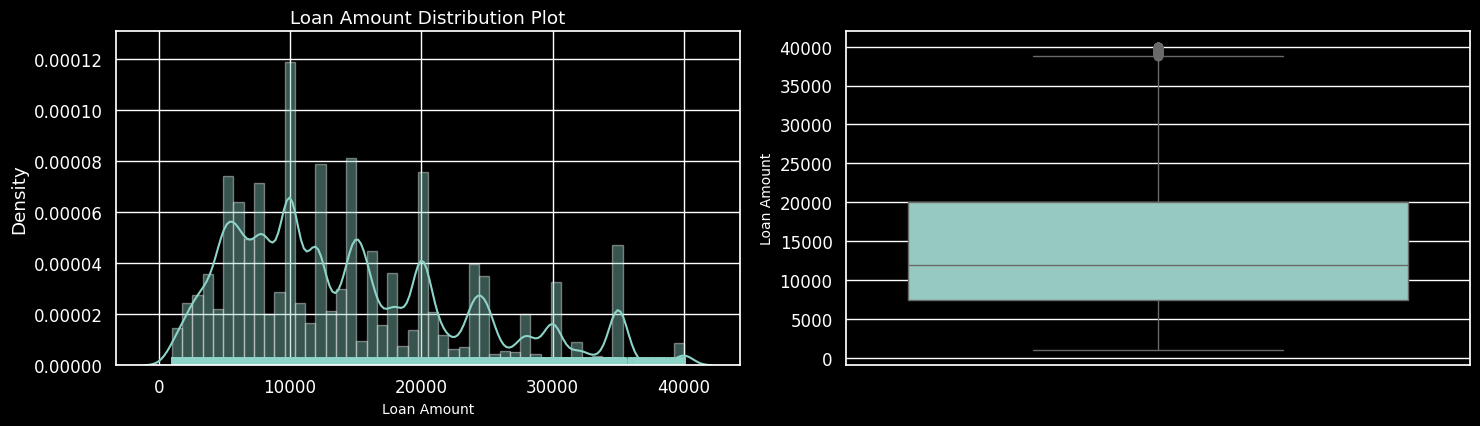

In [180]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(15,8))

    # Subplot 1
    plt.subplot(2,2,1)
    ax = sns.distplot(expired_2019['loan_amnt'], rug=True)
    ax.set(title='Loan Amount Distribution Plot')
    ax.set_xlabel('Loan Amount', fontsize=10, color='w')

    # Subplot 2
    plt.subplot(2,2,2)
    ax = sns.boxplot(y=expired_2019['loan_amnt'])
    ax.set_ylabel('Loan Amount', fontsize=10, color='w')

    # Adjusting overall view
    plt.tight_layout()
    plt.show()


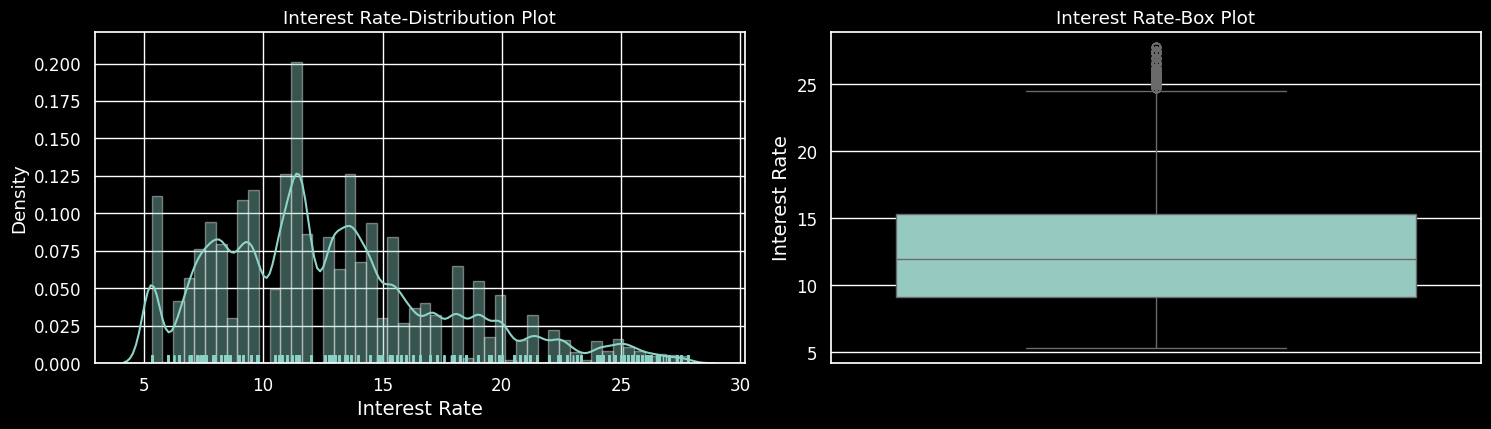


Interest Rate Category	Frequency
10-15%			126079
5-10%			97307
15-20%			55234
20-25%			18478
0-5%			0


In [181]:

with plt.style.context('dark_background'):
    plt.figure(figsize=(15,8))

    # Subplot 1
    plt.subplot(2,2,1)
    ax = sns.distplot(expired_2019['int_rate'], rug=True)
    ax.set(title='Interest Rate-Distribution Plot')
    ax.set_xlabel('Interest Rate', fontsize=14, color='w')

    # Subplot 2
    plt.subplot(2,2,2)
    ax = sns.boxplot(y=expired_2019['int_rate'])
    ax.set(title='Interest Rate-Box Plot')
    ax.set_ylabel('Interest Rate', fontsize=14, color='w')

    # Adjusting overall view
    plt.tight_layout()
    plt.show()

    print()
   # Calculate the frequency of each interest rate category
    int_rate_cat_frequency = expired_2019['int_rate_cat'].value_counts().sort_values(ascending=False)

   # Print the interest rate categories by frequency order
    print("Interest Rate Category\tFrequency")
    for category, count in int_rate_cat_frequency.items():
        print(f"{category}\t\t\t{count}")


**Insghts**
Interest Rate distribution(Most rates are between 10-15%)

**Purpose Loan Analysis**

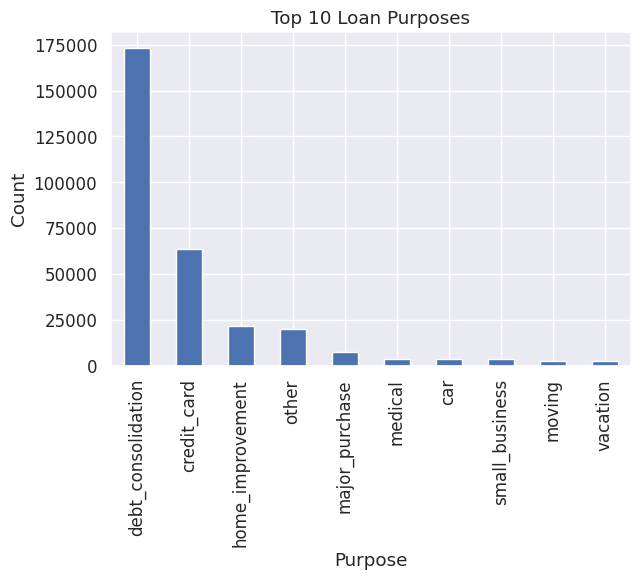

Top 3 Reasons:
1. debt_consolidation: 173295
2. credit_card: 63812
3. home_improvement: 21415


In [182]:
# Count the occurrences of each purpose
purpose_counts = expired_2019['purpose'].value_counts()

# Count the occurrences of each loan status per purpose
status_counts_per_purpose = expired_2019.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

# Replace loan status labels
status_counts_per_purpose = status_counts_per_purpose.rename(columns={0: 'Fully Paid', 1: 'Charged-Off'})

# Plot the top 10 purposes
plt.figure(figsize=(12, 6))

# Plot purpose counts
plt.subplot(1, 2, 1)
purpose_counts.head(10).plot(kind='bar')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Top 10 Loan Purposes')


plt.tight_layout()
plt.show()

# Print the top 3 reasons
print("Top 3 Reasons:")
for i, (purpose, count) in enumerate(purpose_counts.items(), start=1):
    if i <= 3:
        print(f"{i}. {purpose}: {count}")


**Loan Type Distribution**

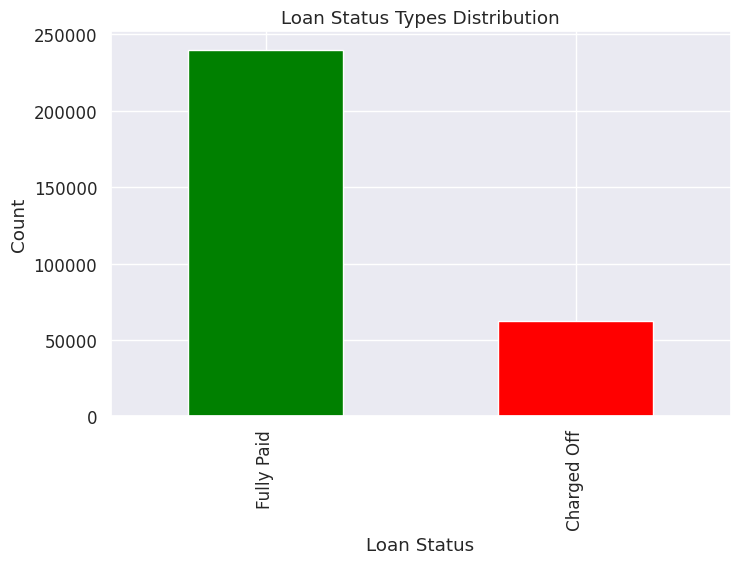


Percentage of Fully Paid: 79.29%
Percentage of Charged Off: 20.71%


In [183]:
# Count the occurrences of each loan status
loan_status_counts = expired_2019['loan_status'].value_counts()

# Define a mapping of status codes to descriptions
status_labels = {0: 'Fully Paid', 1: 'Charged Off'}

# Replace the index in the series with the corresponding labels
loan_status_counts.index = loan_status_counts.index.map(status_labels)

# Define colors for each loan status type
colors = ['green', 'red']

# Plot the distribution of loan status with custom colors
plt.figure(figsize=(8, 5))
loan_status_counts.plot(kind='bar', color=colors)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Types Distribution')
plt.show()

print()

# Count the occurrences of each loan status label
loan_status_counts = expired_2019['loan_status'].map(status_labels).value_counts()

# Calculate the percentage of each loan status
fully_paid_percentage = loan_status_counts['Fully Paid'] / len(expired_2019) * 100
charged_off_percentage = loan_status_counts['Charged Off'] / len(expired_2019) * 100

# Print the percentages
print(f"Percentage of Fully Paid: {fully_paid_percentage:.2f}%")
print(f"Percentage of Charged Off: {charged_off_percentage:.2f}%")

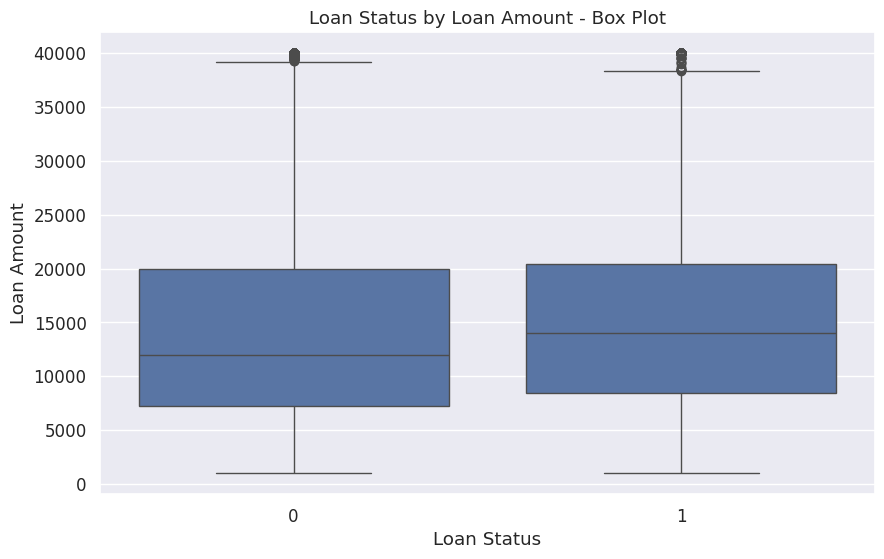

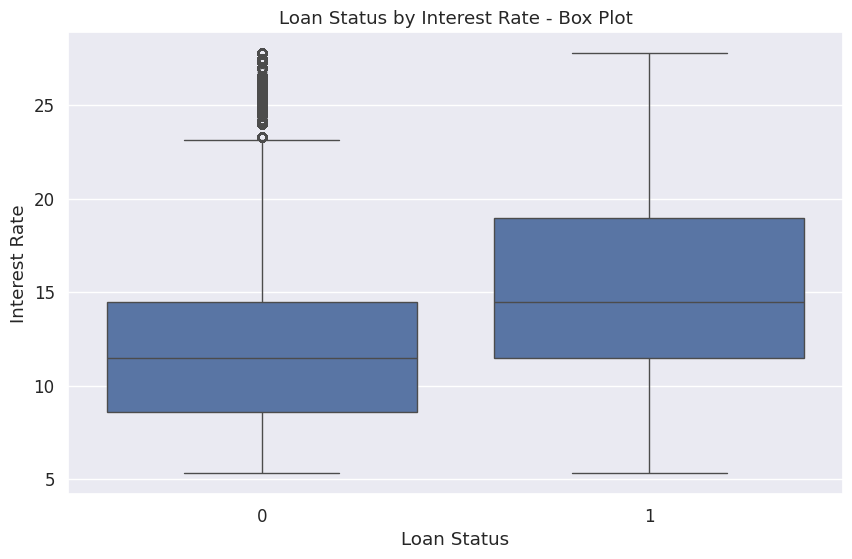

In [184]:
# Loan status by loan amount - box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=expired_2019)
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.title('Loan Status by Loan Amount - Box Plot')
plt.show()

# Loan status by interest rate - box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='int_rate', data=expired_2019)
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
plt.title('Loan Status by Interest Rate - Box Plot')
plt.show()


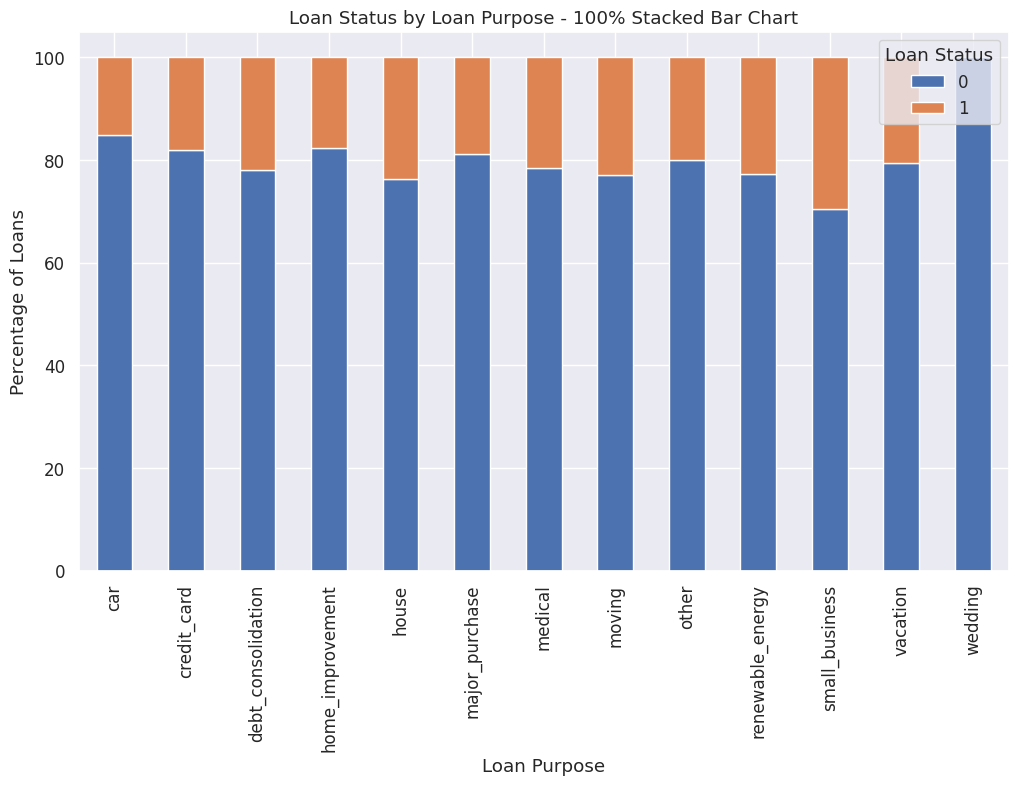

In [185]:

# Assuming 'expired_2019' is already loaded and mapped as described earlier.

# Pivot the data to get total counts
pivot_data = expired_2019.pivot_table(index='purpose', columns='loan_status', aggfunc='size', fill_value=0)

# Convert counts to proportions
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.xlabel('Loan Purpose')
plt.ylabel('Percentage of Loans')
plt.title('Loan Status by Loan Purpose - 100% Stacked Bar Chart')
plt.legend(title='Loan Status')
plt.show()





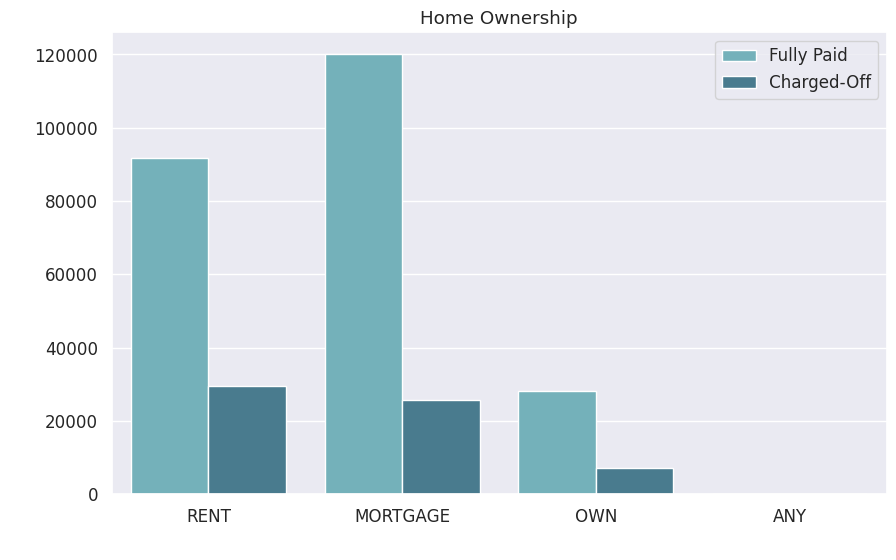

In [186]:

# Map loan status values to their corresponding labels
status_labels = {0: 'Fully Paid', 1: 'Charged-Off'}
expired_2019['loan_status_label'] = expired_2019['loan_status'].map(status_labels)

# Plot countplot with updated labels
plt.figure(figsize=(10,6))
ax = sns.countplot(x="home_ownership", data=expired_2019, hue='loan_status_label', palette='GnBu_d')
ax.legend(bbox_to_anchor=(1,1))
ax.set(title='Home Ownership')
ax.set_xlabel('Home Ownership', fontsize=14, color='w')
ax.set_ylabel('Loan Application Count', fontsize=14, color='w')
plt.show()


**Home Ownership**

The count plot reveals that the majority of applicants either rent their homes or have mortgaged them. These two categories account for a significant portion of the applicant pool. Consequently, the number of charged-off loans is also high within these categories.


**Proportion of Sub-Grades by Top 15 Employee Titles**

In [187]:
# Top 15 employee titles
top_15_titles = expired_2019['emp_title'].value_counts()[:15].index.values

# Crosstab of grade and employee title
crosstab = pd.crosstab(expired_2019['emp_title'], expired_2019['sub_grade'])  # Switched the order of columns

# Filter crosstab to include only top 15 employee titles
crosstab_top15 = crosstab.loc[top_15_titles]  # Used .loc to filter rows by employee titles

# Background gradient setup
cm = sns.light_palette("green", as_cmap=True)

# Normalize crosstab by index and round to 2 decimal places, then apply background gradient
formatted_crosstab_top15 = round(crosstab_top15.div(crosstab_top15.sum(axis=1), axis=0) * 100, 2)

formatted_crosstab_top15.style.background_gradient(cmap=cm)



sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
emp_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Teacher,4.830000,3.300000,2.700000,3.360000,4.680000,5.930000,6.270000,6.520000,7.010000,7.860000,7.220000,6.420000,5.210000,5.680000,4.800000,3.010000,2.810000,2.080000,2.100000,1.610000,1.500000,1.000000,0.730000,0.780000,0.740000,0.520000,0.340000,0.410000,0.250000,0.250000,0.070000,0.020000,0.000000,0.000000,0.000000
Manager,4.340000,2.340000,2.450000,3.450000,4.110000,5.190000,5.660000,6.270000,6.440000,7.480000,7.350000,6.210000,6.120000,6.090000,5.480000,3.270000,3.120000,2.500000,2.700000,1.840000,1.480000,1.230000,1.270000,0.930000,0.660000,0.610000,0.480000,0.370000,0.370000,0.160000,0.040000,0.000000,0.000000,0.000000,0.000000
Owner,6.960000,3.550000,2.990000,3.860000,4.140000,6.820000,5.970000,6.590000,6.790000,6.540000,6.510000,5.830000,4.540000,5.720000,4.030000,3.630000,3.210000,2.450000,1.970000,1.440000,1.300000,1.160000,0.790000,0.760000,0.730000,0.340000,0.280000,0.250000,0.370000,0.310000,0.110000,0.060000,0.000000,0.000000,0.000000
Driver,2.670000,1.800000,2.080000,3.110000,2.990000,5.150000,5.950000,4.870000,6.750000,7.940000,6.670000,6.390000,6.030000,5.870000,4.630000,4.550000,4.390000,3.150000,2.990000,2.400000,2.040000,1.240000,1.320000,1.400000,1.240000,0.800000,0.320000,0.640000,0.320000,0.160000,0.160000,0.000000,0.000000,0.000000,0.000000
Registered Nurse,5.230000,3.220000,3.220000,4.220000,4.260000,7.080000,5.470000,6.190000,6.560000,7.200000,6.560000,5.470000,5.150000,5.830000,5.150000,3.140000,3.020000,2.370000,1.850000,1.410000,1.410000,1.050000,1.090000,0.800000,1.130000,0.520000,0.400000,0.400000,0.400000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
RN,6.470000,2.830000,3.190000,4.120000,4.410000,6.470000,5.460000,6.870000,6.430000,7.160000,6.870000,6.030000,5.580000,5.420000,4.210000,3.720000,3.230000,2.060000,1.980000,1.620000,0.970000,0.850000,0.890000,0.810000,0.850000,0.440000,0.360000,0.280000,0.200000,0.120000,0.080000,0.000000,0.000000,0.000000,0.000000
Supervisor,4.340000,1.840000,1.600000,3.070000,3.560000,4.260000,5.900000,5.810000,6.550000,7.130000,7.130000,6.100000,5.690000,5.320000,5.690000,3.600000,3.190000,3.030000,3.030000,2.540000,1.720000,1.640000,1.640000,1.470000,1.270000,0.820000,0.570000,0.530000,0.330000,0.410000,0.200000,0.000000,0.000000,0.000000,0.000000
Sales,4.990000,2.630000,2.450000,3.580000,4.310000,5.890000,5.170000,6.260000,6.710000,8.160000,6.890000,5.760000,6.120000,5.710000,5.210000,3.450000,2.950000,2.450000,2.220000,1.810000,1.410000,0.950000,1.270000,1.310000,0.630000,0.500000,0.180000,0.270000,0.320000,0.360000,0.090000,0.000000,0.000000,0.000000,0.000000
Project Manager,7.700000,3.130000,2.780000,4.230000,4.630000,6.020000,5.790000,6.950000,5.500000,7.180000,7.640000,6.020000,4.570000,5.500000,4.860000,2.550000,2.720000,1.910000,2.030000,1.740000,1.220000,0.930000,0.980000,0.640000,0.870000,0.520000,0.690000,0.350000,0.120000,0.120000,0.060000,0.060000,0.000000,0.000000,0.000000


**Insights (crosstab)**

The table reveals that Directors, Engineers, Presidents, and Vice Presidents are the most common categories within Grade A. This analysis provides valuable insights into the relationship between job titles and loan grades.








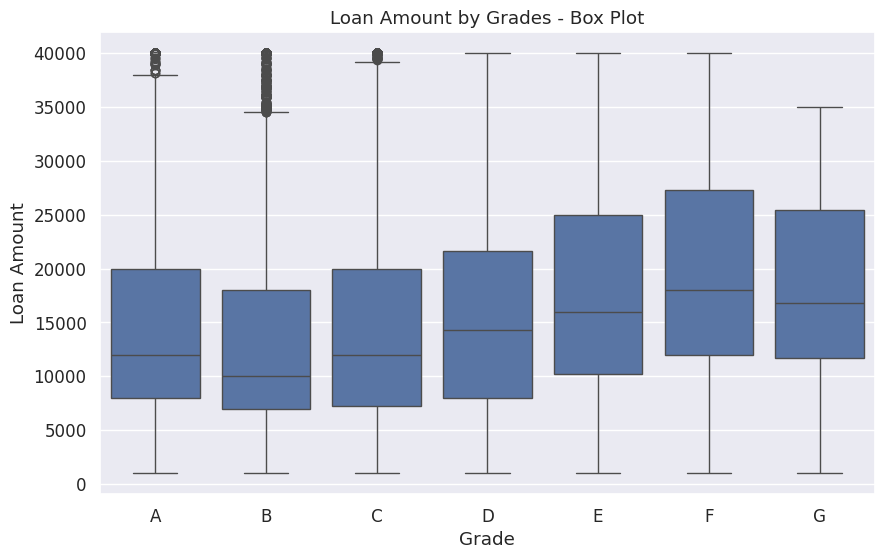

In [188]:
# plot Loan amount by grades

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='loan_amnt', data=expired_2019, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Grades - Box Plot')
plt.show()


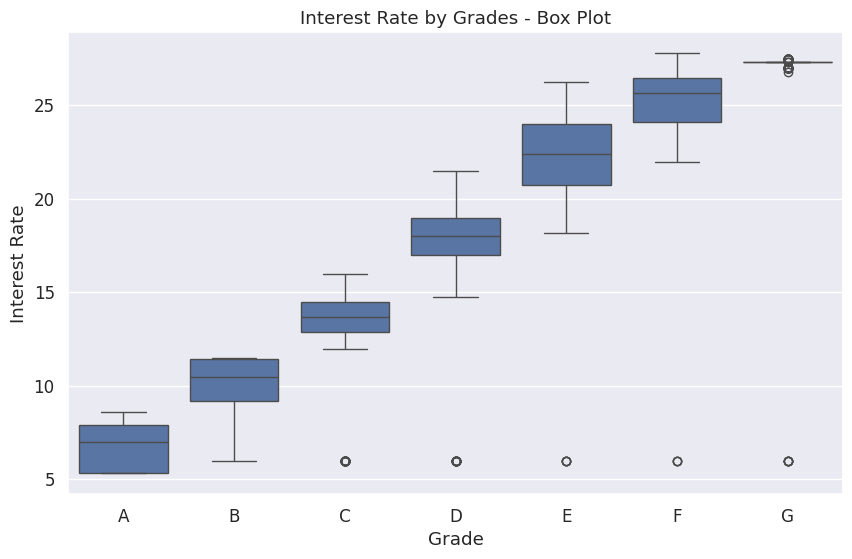

In [189]:
# plot Interest rate by grades and sort it by grade

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=expired_2019, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Grade')
plt.ylabel('Interest Rate')
plt.title('Interest Rate by Grades - Box Plot')
plt.show()


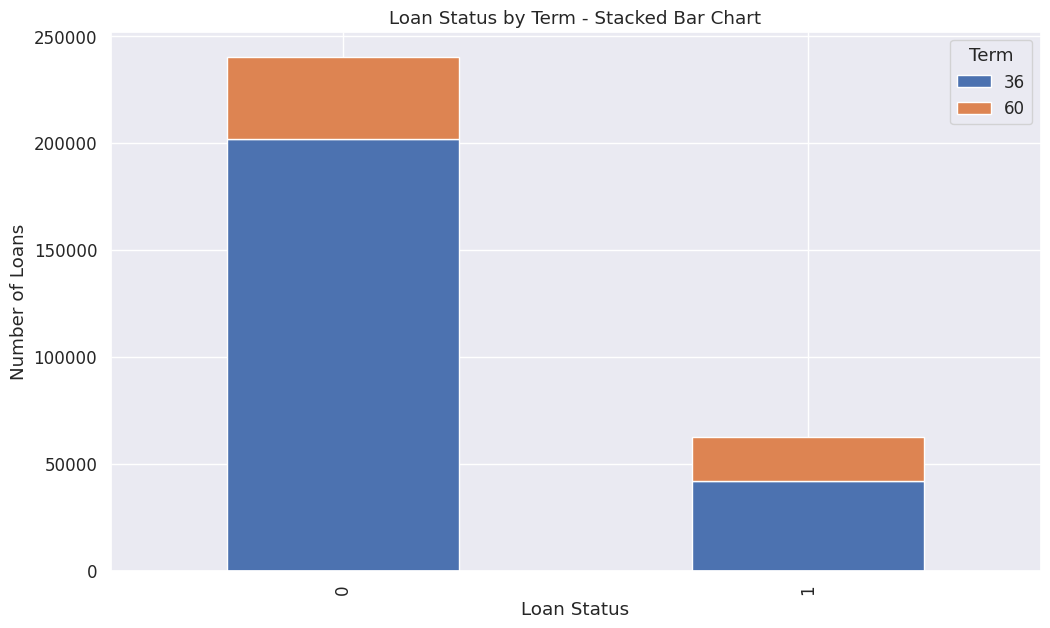

In [190]:
# plot loan status by term
# Assuming 'expired_2019' is already loaded and mapped as described earlier.

# Group data by loan status and term
grouped_data = expired_2019.groupby(['loan_status', 'term']).size().unstack()

# Plot the grouped data as a bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.xlabel('Loan Status')
plt.ylabel('Number of Loans')
plt.title('Loan Status by Term - Stacked Bar Chart')
plt.legend(title='Term')
plt.show()


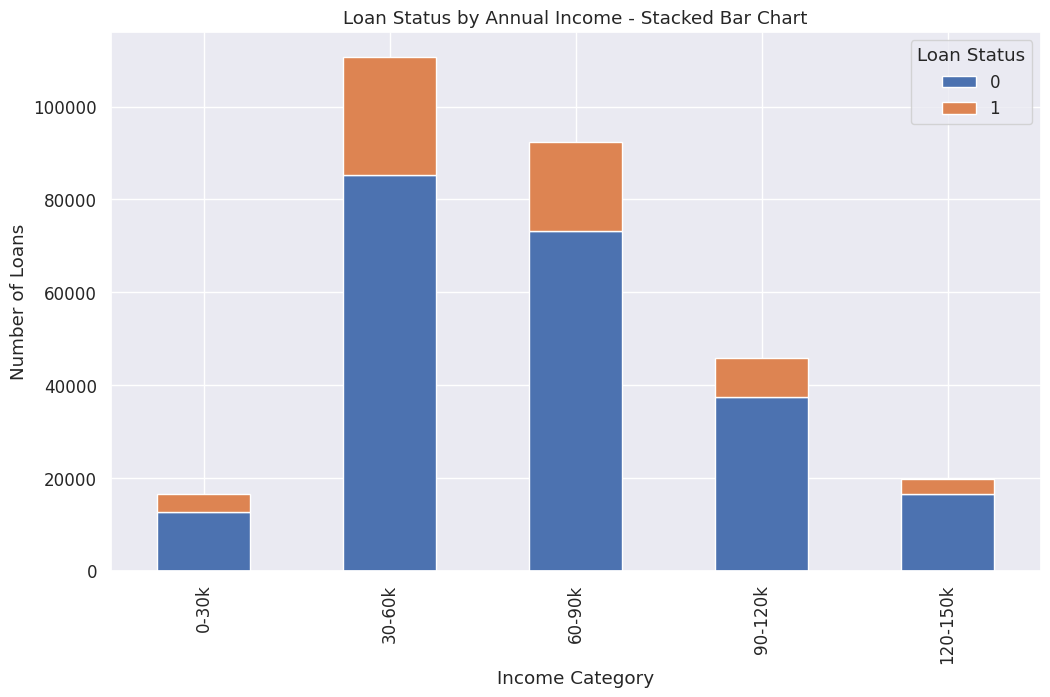

In [191]:
# Assuming 'expired_2019' is your DataFrame and it's already loaded.

# Create income bins
bins = [0, 30000, 60000, 90000, 120000, 150000]
labels = ['0-30k', '30-60k', '60-90k', '90-120k', '120-150k']

# Bin income and create a new column
expired_2019['income_category'] = pd.cut(expired_2019['annual_inc'], bins=bins, labels=labels)

# Group data by income category and then by loan status
grouped_data = expired_2019.groupby(['income_category', 'loan_status']).size().unstack()

# Plot the grouped data as a bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.xlabel('Income Category')
plt.ylabel('Number of Loans')
plt.title('Loan Status by Annual Income - Stacked Bar Chart')
plt.legend(title='Loan Status')
plt.show()



### Correlation Matrixes

Picking the suitable feautures for the correlation maps

In [192]:
# # prompt: using a forloop fprint all the numerical features of expired_2019

# numerical_features = expired_2019.select_dtypes(include=['int64', 'float64']).columns

# for feature in numerical_features:
#     print(feature)


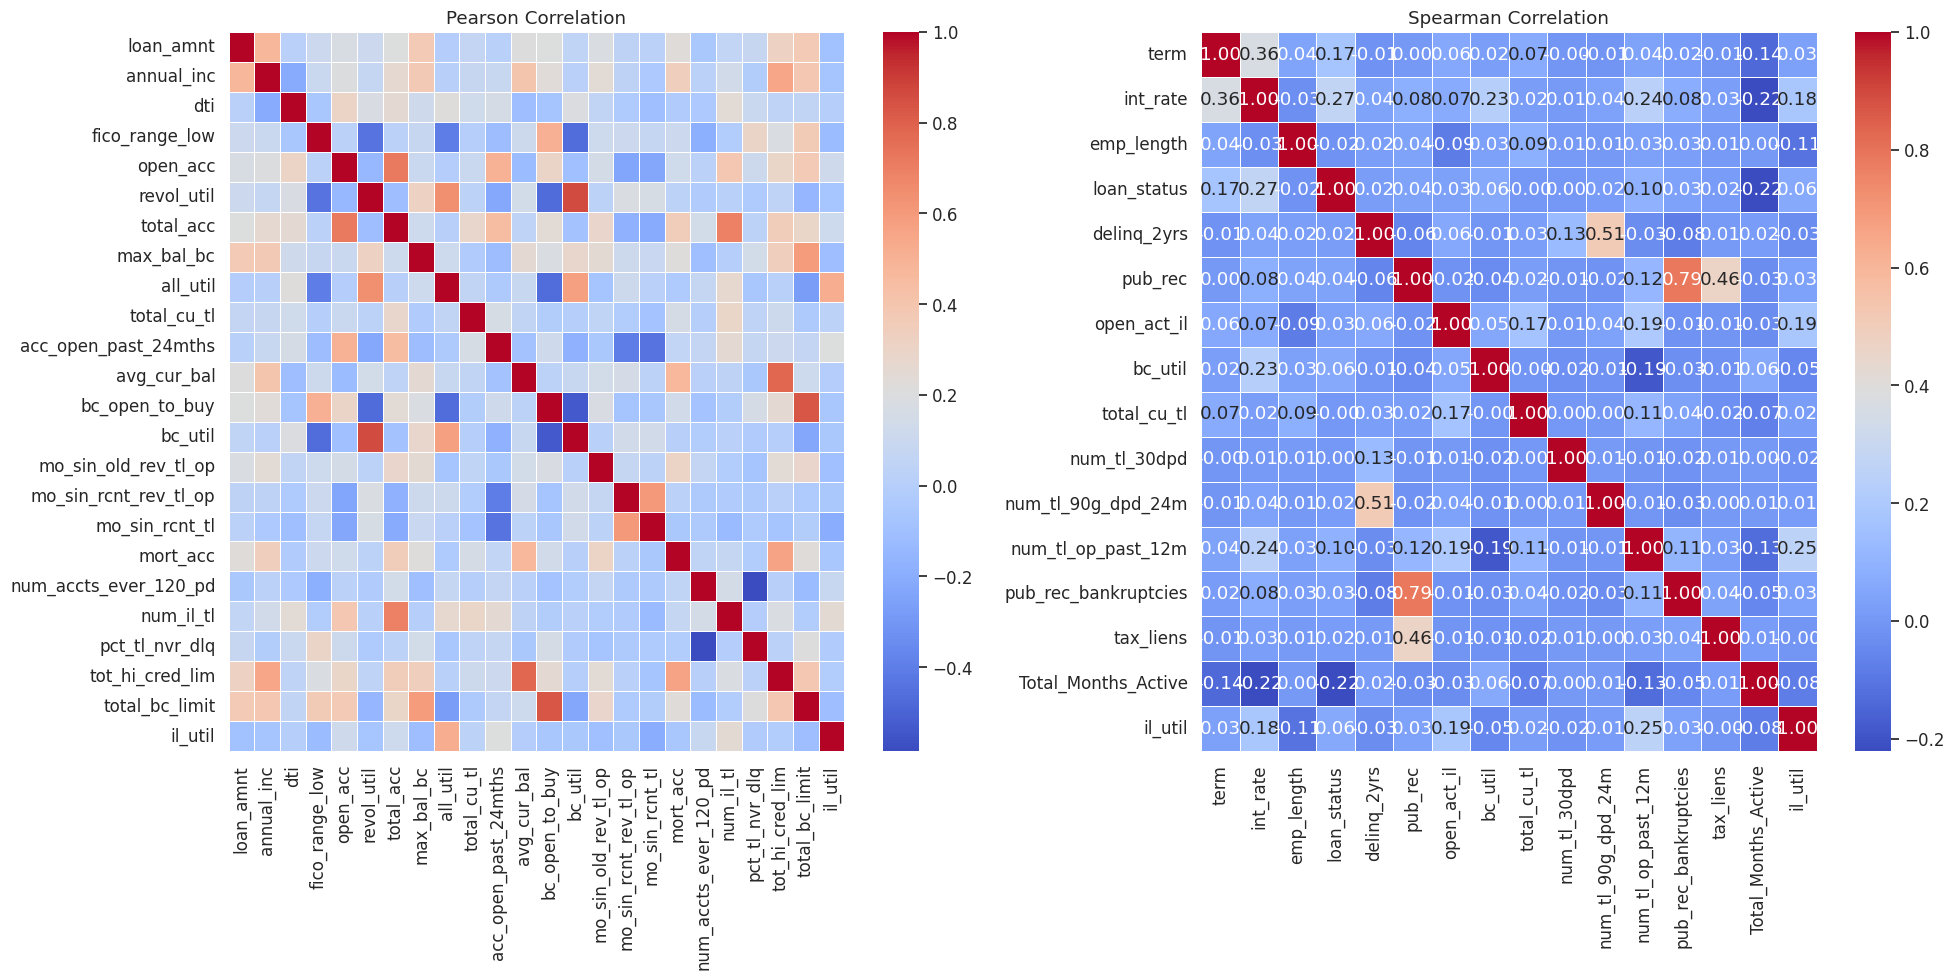

In [193]:
# Features for Pearson Correlation
# Pearson Features
pearson_features = [
    'loan_amnt' , 'annual_inc', 'dti', 'fico_range_low',
     'open_acc', 'revol_util', 'total_acc',
    'max_bal_bc', 'all_util', 'total_cu_tl', 'acc_open_past_24mths',
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util','mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd',
    'num_il_tl', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim',
    'total_bc_limit','il_util'
]

# Spearman Features
spearman_features = [
    'term', 'int_rate', 'emp_length', 'loan_status', 'delinq_2yrs', 'pub_rec',
    'open_act_il','bc_util', 'total_cu_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens'
    , 'Total_Months_Active','il_util'
]


# Calculate correlations
pearson_corr = expired_2019[pearson_features].corr(method='pearson')
spearman_corr = expired_2019[spearman_features].corr(method='spearman')

# Plot heatmaps with larger figures
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation')

plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation')

plt.tight_layout()
plt.show()

Correlation numbers

In [194]:
loan_correlation=expired_2019[pearson_features].corr()
# loan_correlation

The clustering helps to identify groups of features that are highly correlated with each other.

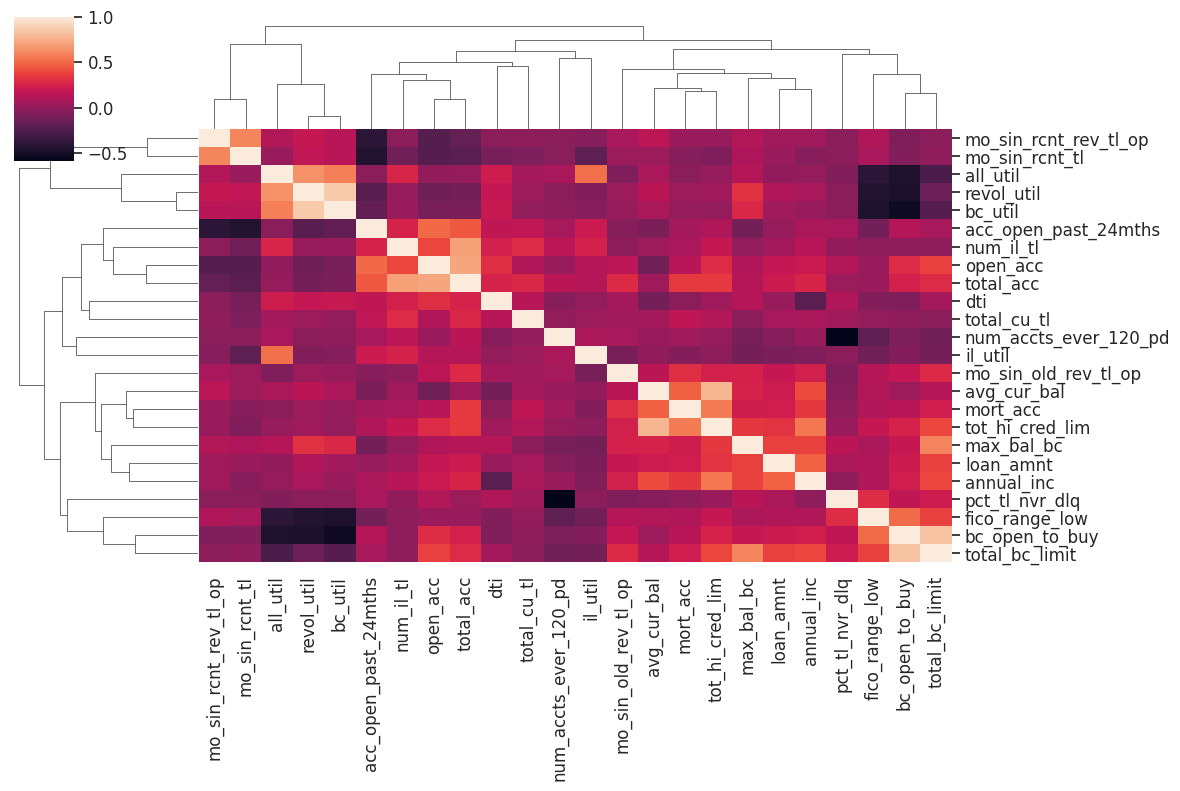

In [195]:
sns.set(font_scale=1.1)
sns.clustermap(loan_correlation,annot=False,figsize=(12,8))
plt.show()

### Bivariate Analysis (Charged-Off two-factor analysis )


Annual inc category

In [196]:
# Group by annual income category and loan status, and count the occurrences
inc_range_vs_loan = expired_2019.groupby(['annual_inc_cat', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()

# Rename the columns to 'Charged-Off' and 'Fully Paid'
inc_range_vs_loan = inc_range_vs_loan.rename(columns={1: 'Charged-Off', 0: 'Fully Paid'})

# Calculate total count of loans in each income category
inc_range_vs_loan['Total'] = inc_range_vs_loan['Charged-Off'] + inc_range_vs_loan['Fully Paid']

# Calculate the proportion of charged-off loans within each income category
inc_range_vs_loan['Chargedoff_Proportion'] = inc_range_vs_loan['Charged-Off'] / inc_range_vs_loan['Total']

# Sort by charged-off proportion in descending order
inc_range_vs_loan = inc_range_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

# Display the adjusted DataFrame
inc_range_vs_loan


loan_status,annual_inc_cat,Fully Paid,Charged-Off,Total,Chargedoff_Proportion
1,20000-40000,33388,10426,43814,0.237960
2,40000-60000,62612,18144,80756,0.224677
0,0-20000,1966,568,2534,0.224152
3,60000-80000,53710,14287,67997,0.210112
4,80000+,88277,19235,107512,0.178910


Plot of the above

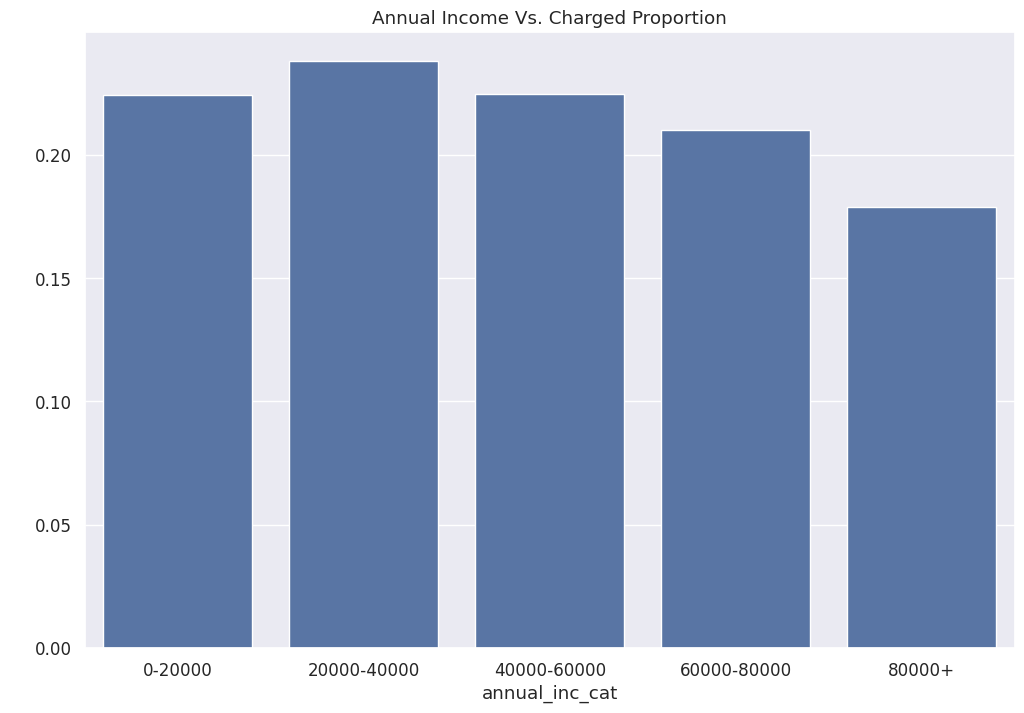

In [197]:
fig,ax1=plt.subplots(figsize=(12,8))
ax1.set(title='Annual Income Vs. Charged Proportion')
ax1=sns.barplot(x='annual_inc_cat',y='Chargedoff_Proportion',data=inc_range_vs_loan)
ax.set_xlabel('Charged Off Proportion',fontsize=14,color='w')
ax1.set_ylabel('Annual Income',fontsize=14,color='w')
plt.show()

Insights from above :
1. Applicants with an income range of 80000 or more exhibit lower instances of
charged-off loans.

2. Conversely, those with an income range of 20000-4000 are more likely to experience charged-off loans.

3. Notably, there's an inverse relationship between annual income and charged-off proportion; as income increases, the likelihood of charged-off loans decreases.

Purpose vs Charged off

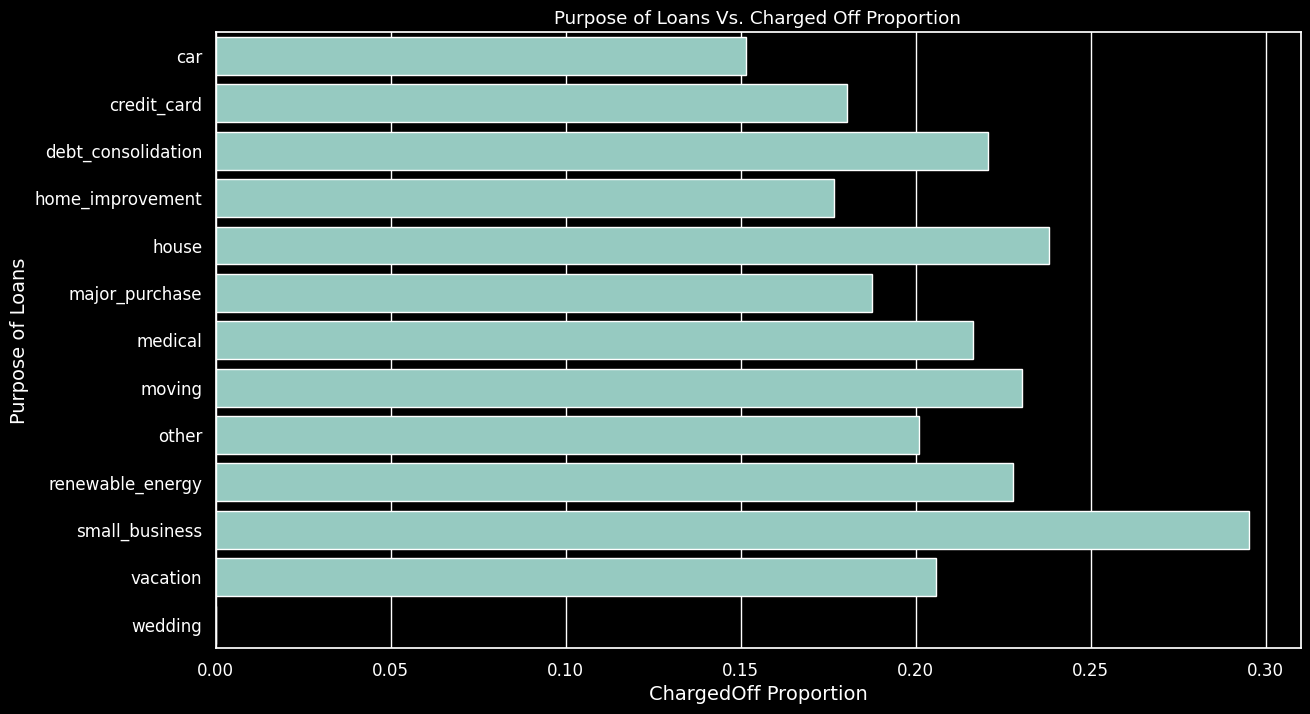

In [198]:
# Group by purpose and loan_status and count occurrences
purpose_vs_loan = expired_2019.groupby(['purpose', 'loan_status'])['loan_status'].count().unstack().fillna(0)

# Reset index to make 'purpose' a regular column
purpose_vs_loan.reset_index(inplace=True)

# Calculate total count of loans for each purpose
purpose_vs_loan['Total'] = purpose_vs_loan[0] + purpose_vs_loan[1]

# Calculate proportion of charged-off loans for each purpose
purpose_vs_loan['ChargedOff_Proportion'] = purpose_vs_loan[1] / purpose_vs_loan['Total']

# Sort by proportion of charged-off loans in descending order
purpose_vs_loan_sorted = purpose_vs_loan.sort_values('ChargedOff_Proportion', ascending=False)

with plt.style.context('dark_background'):
  fig,ax1=plt.subplots(figsize=(14,8))
  ax1.set(title='Purpose of Loans Vs. Charged Off Proportion')
  ax1=sns.barplot(y='purpose',x='ChargedOff_Proportion',data=purpose_vs_loan)
  ax1.set_ylabel('Purpose of Loans',fontsize=14,color='w')
  ax1.set_xlabel('ChargedOff Proportion',fontsize=14,color='w')


Insights
1. Small business applicants are more likely to be charged off compared to other categories.
2. The 'car' category has a relatively lower proportion of charged-off loans compared to other categories.

Grades vs charged off prop

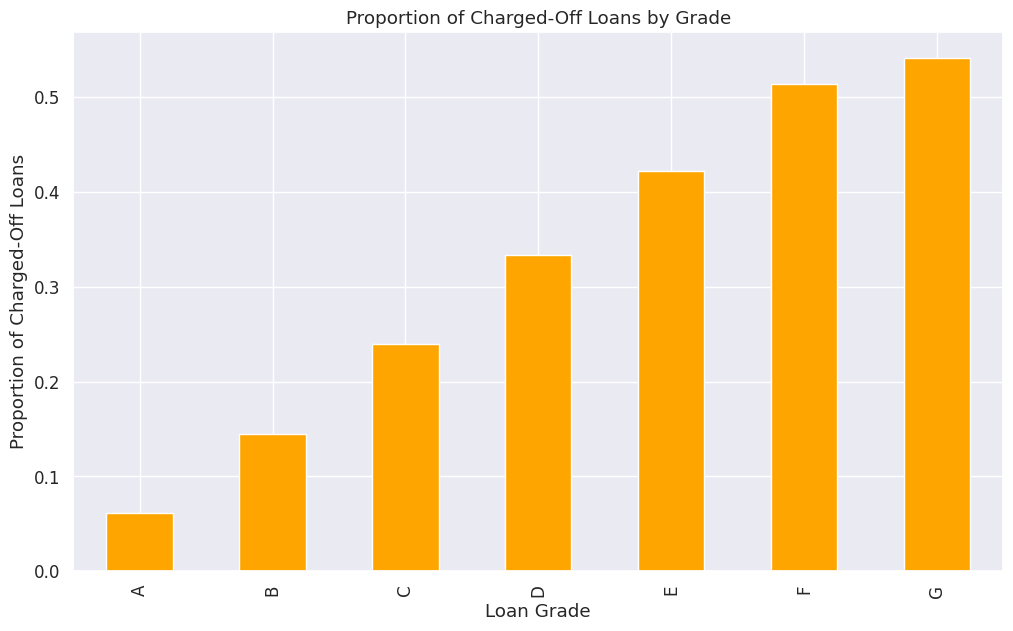

In [199]:
import matplotlib.pyplot as plt

# Group data by grade and then by loan status
grouped_data = expired_2019.groupby('grade')['loan_status'].value_counts(normalize=True).unstack()

# Reorder grades alphabetically or in the desired order
grouped_data = grouped_data.reindex(sorted(grouped_data.index))

# Plot the proportion of 'Charged-Off' loans by grade
grouped_data[1].plot(kind='bar', figsize=(12, 7), color='orange')
plt.xlabel('Loan Grade')
plt.ylabel('Proportion of Charged-Off Loans')
plt.title('Proportion of Charged-Off Loans by Grade')
plt.show()


Insights:

As grades move from A to G, the likelihood of being charged off increases, with Grade A having the lowest and Grades F and G having the highest chances of being charged off

**Sub-grade vs Charged-Off prop**

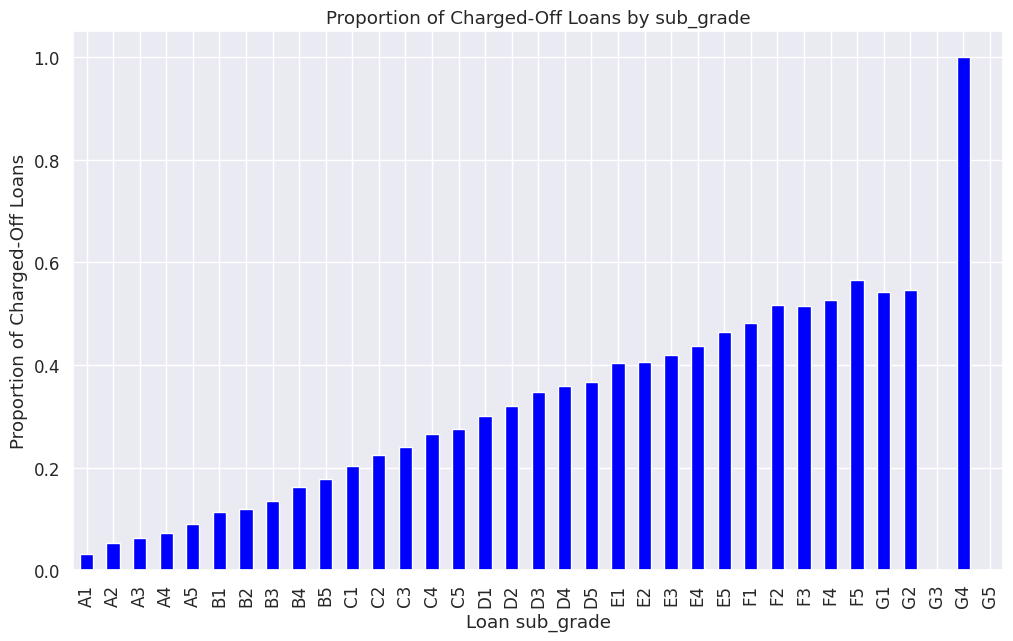

In [200]:

# Group data by grade and then by loan status
grouped_data = expired_2019.groupby('sub_grade')['loan_status'].value_counts(normalize=True).unstack()

# Reorder grades alphabetically or in the desired order
grouped_data = grouped_data.reindex(sorted(grouped_data.index))

# Plot the proportion of 'Charged-Off' loans by grade
grouped_data[1].plot(kind='bar', figsize=(12, 7), color='blue')
plt.xlabel('Loan sub_grade')
plt.ylabel('Proportion of Charged-Off Loans')
plt.title('Proportion of Charged-Off Loans by sub_grade')
plt.show()

We can see a very lear increase off charged of prop by subgrade with A1 having the lowest charged-off proportion (with a slight discrepancy between G1-3)

Interest Vs Charged-Off

In [201]:
# # Group data by grade and then by loan status
# grouped_data = expired_2019.groupby('int_rate_cat')['loan_status'].value_counts(normalize=True).unstack()

# # Plot the proportion of 'Charged-Off' loans by grade
# grouped_data[1].plot(kind='bar', figsize=(12, 7), color='green')
# plt.xlabel('int_rate_cat')
# plt.ylabel('Proportion of Charged-Off Loans')
# plt.title('Proportion of Charged-Off Loans by Int_rate Category')
# plt.show()

**Add Insights!!!!**

State vs ChargedOff Prop

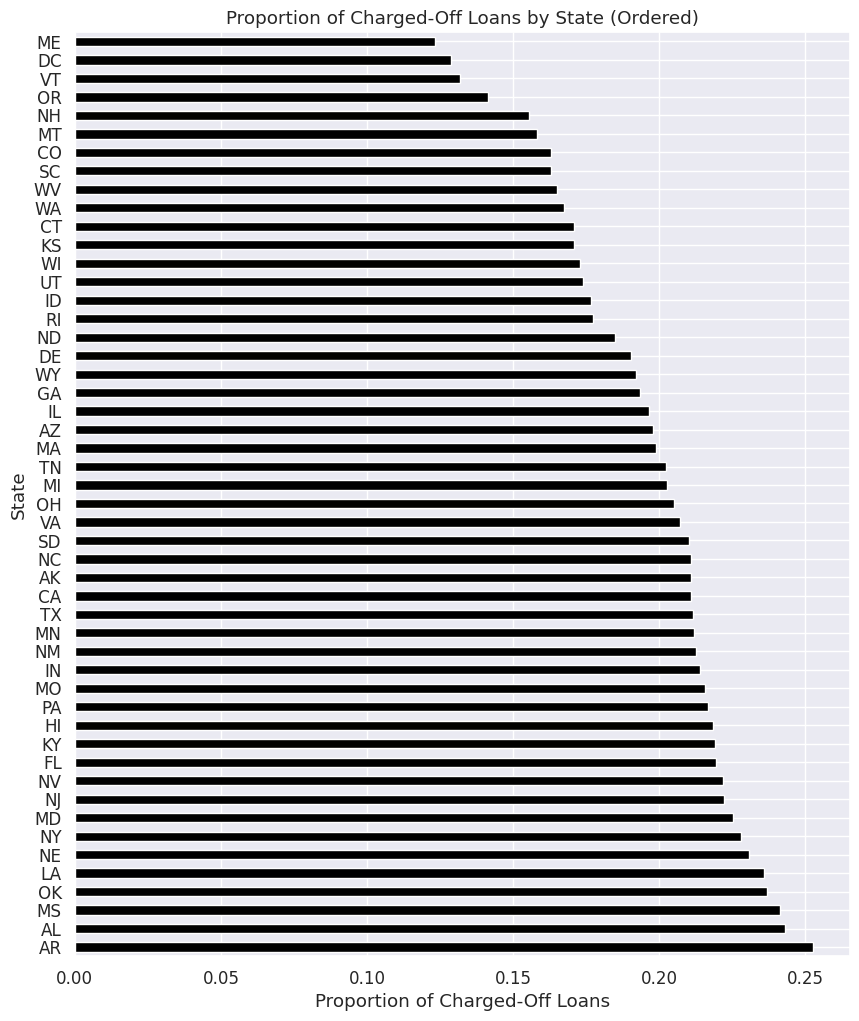

In [202]:
import matplotlib.pyplot as plt

# Group data by state and then by loan status
grouped_data = expired_2019.groupby('addr_state')['loan_status'].value_counts(normalize=True).unstack()

# Calculate the proportion of charged-off loans
grouped_data['ChargedOff_Proportion'] = grouped_data[1]

# Sort by 'ChargedOff_Proportion' in descending order
grouped_data_sorted = grouped_data.sort_values('ChargedOff_Proportion', ascending=False)

# Plot the proportion of 'Charged-Off' loans by state
plt.figure(figsize=(10, 12))  # Adjust figure size to accommodate rotated labels
grouped_data_sorted['ChargedOff_Proportion'].plot(kind='barh', color='black')
plt.xlabel('Proportion of Charged-Off Loans')
plt.ylabel('State')
plt.title('Proportion of Charged-Off Loans by State (Ordered)')
plt.show()


In [203]:
# Sort by 'ChargedOff_Proportion' in descending order
grouped_data_sorted = grouped_data.sort_values('ChargedOff_Proportion', ascending=False)

# Print top 10 highest ChargedOff_Proportion
print("Top 10 Highest ChargedOff_Proportion:")
print(grouped_data_sorted[['ChargedOff_Proportion']].head(10))

# Sort by 'ChargedOff_Proportion' in ascending order for lowest values
grouped_data_sorted_lowest = grouped_data_sorted.sort_values('ChargedOff_Proportion', ascending=True)

# Print top 10 lowest ChargedOff_Proportion
print("\nTop 10 Lowest ChargedOff_Proportion:")
print(grouped_data_sorted_lowest[['ChargedOff_Proportion']].head(10))


Top 10 Highest ChargedOff_Proportion:
loan_status  ChargedOff_Proportion
addr_state                        
AR                        0.252708
AL                        0.243102
MS                        0.241253
OK                        0.237048
LA                        0.235775
NE                        0.230718
NY                        0.228172
MD                        0.225166
NJ                        0.222232
NV                        0.221888

Top 10 Lowest ChargedOff_Proportion:
loan_status  ChargedOff_Proportion
addr_state                        
ME                        0.123391
DC                        0.128671
VT                        0.131955
OR                        0.141393
NH                        0.155540
MT                        0.158084
CO                        0.162955
SC                        0.163025
WV                        0.164966
WA                        0.167467
